In [1]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PREDICCIÓN DE DEMANDA TURÍSTICA EN MENDOZA
════════════════════════════════════════════════════════════════════════════════

OBJETIVO PREDICTIVO:
   Predecir el número mensual de turistas que visitan Mendoza según:
   - Características económicas (precio USD)
   - Características temporales (mes, año)
   - Origen del turista (país)
   - Punto de entrada (aeropuerto, paso fronterizo)

TIPO DE PROBLEMA: Regresión
   - Variable objetivo: turistas (numérica continua)
   - Métricas: RMSE, MAE, R²

DATASET: mendoza_turismo_final_filtrado.csv
   - Período: 2014-2025
   - Registros mensuales agregados por país y punto de entrada
   
════════════════════════════════════════════════════════════════════════════════
"""

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Estilo de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Configuración completa")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"🎲 Semilla aleatoria: {RANDOM_STATE}")

✅ Configuración completa
📅 Fecha: 2025-11-04 15:32
🎲 Semilla aleatoria: 42



📂 CARGA DE DATOS
✅ Dataset cargado exitosamente
   • Dimensiones: 2,877 filas × 31 columnas
   • Memoria: 1.15 MB

--------------------------------------------------------------------------------
🔍 PRIMERAS FILAS DEL DATASET
--------------------------------------------------------------------------------
  indice_tiempo               pais_origen            punto_entrada  turistas  \
0       2014-01                    Brasil       Aeropuerto Córdoba       654   
1       2014-01                     Chile       Aeropuerto Córdoba      1046   
2       2014-01    Ee.Uu, Canadá Y México       Aeropuerto Córdoba      1211   
3       2014-01  Europa Y Resto Del Mundo       Aeropuerto Córdoba       719   
4       2014-01          Resto De América       Aeropuerto Córdoba       763   
5       2014-01           Resto Del Mundo      Puerto Buenos Aires      2135   
6       2014-01                   Uruguay      Puerto Buenos Aires     14122   
7       2014-02                   Bolivia  Aeropuerto

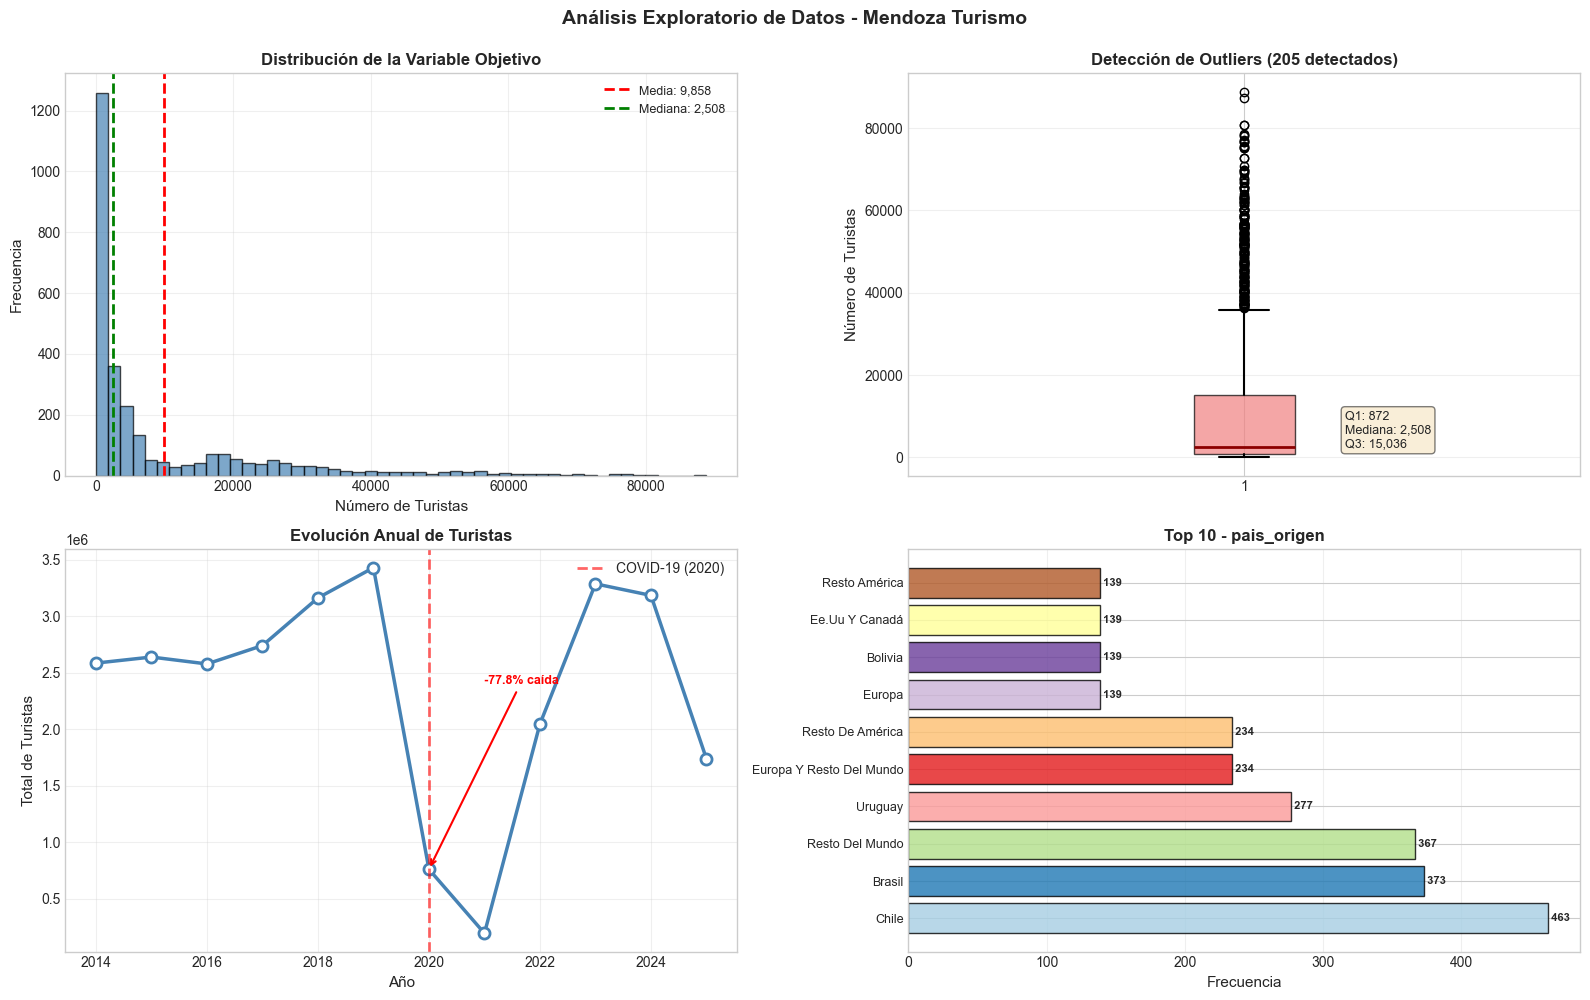


📋 RESUMEN DE LA EXPLORACIÓN

✅ DATASET CARGADO Y EXPLORADO:
   • Registros: 2,877
   • Variables: 29 (25 numéricas + 2 categóricas)
   • Variable objetivo: turistas (media=9,858, std=15,070)

⚠️ PROBLEMAS IDENTIFICADOS:
   • Outliers: 205 (7.1%) → MANTENER
   • Registros con 0: 389 (13.52%) → ELIMINAR en Celda 3
   • Valores nulos: 5754 → Ya tratados
   • Duplicados: 0 → No hay

📊 DISTRIBUCIÓN:
   • Rango: 0 - 88,814
   • Coeficiente de variación: 152.9% (Alta variabilidad)
   • Asimetría detectada (probablemente sesgada a la derecha)

🎯 PRÓXIMOS PASOS:
   1. Eliminar registros con 0 turistas (Celda 3)
   2. Construir pipeline de preprocesamiento (Celda 3)
   3. Split temporal train/test 80/20 (Celda 3)
   4. Entrenar y comparar modelos (Celda 4)

✅ EXPLORACIÓN COMPLETADA


In [2]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 1: EXPLORACIÓN Y ENTENDIMIENTO DE LOS DATOS
════════════════════════════════════════════════════════════════════════════════
Objetivo: Conocer la estructura, calidad y características del dataset antes
          de aplicar cualquier transformación o limpieza.
          
Autor: Juliccc
Fecha: 2025-11-04
"""

# ═══════════════════════════════════════════════════════════════════════════
# CARGA DE DATOS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📂 CARGA DE DATOS")
print("="*80)

# Cargar dataset
df = pd.read_csv('mendoza_turismo_final_filtrado.csv', sep=';', encoding='utf-8')

# Crear copia de seguridad para análisis posteriores
df_original = df.copy()

print(f"✅ Dataset cargado exitosamente")
print(f"   • Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"   • Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# ═══════════════════════════════════════════════════════════════════════════
# INSPECCIÓN INICIAL
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("🔍 PRIMERAS FILAS DEL DATASET")
print("-"*80)
print(df.head(10))

print("\n" + "-"*80)
print("📋 INFORMACIÓN DE COLUMNAS")
print("-"*80)
df.info()

print("\n" + "-"*80)
print("📊 ESTADÍSTICAS DESCRIPTIVAS")
print("-"*80)
print(df.describe())

# ═══════════════════════════════════════════════════════════════════════════
# ANÁLISIS DE LA VARIABLE OBJETIVO
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("🎯 ANÁLISIS DE LA VARIABLE OBJETIVO: 'turistas'")
print("="*80)

print(f"\n📊 Estadísticas básicas:")
print(df['turistas'].describe())

print(f"\n   • Media: {df['turistas'].mean():,.0f} turistas/mes")
print(f"   • Mediana: {df['turistas'].median():,.0f} turistas/mes")
print(f"   • Desviación estándar: {df['turistas'].std():,.0f}")
print(f"   • Mínimo: {df['turistas'].min():,.0f}")
print(f"   • Máximo: {df['turistas'].max():,.0f}")
print(f"   • Rango: {df['turistas'].max() - df['turistas'].min():,.0f}")

# Coeficiente de variación
cv = (df['turistas'].std() / df['turistas'].mean()) * 100
print(f"   • Coeficiente de variación: {cv:.1f}%")
if cv > 100:
    print(f"     → Alta variabilidad en los datos")
elif cv > 50:
    print(f"     → Variabilidad moderada")
else:
    print(f"     → Baja variabilidad")

# ═══════════════════════════════════════════════════════════════════════════
# IDENTIFICACIÓN DE TIPOS DE VARIABLES
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📋 CLASIFICACIÓN DE VARIABLES")
print("="*80)

# Variables numéricas (excluyendo objetivo)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'turistas' in numeric_features:
    numeric_features.remove('turistas')

# Variables categóricas
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Eliminar columnas de fecha que no son predictoras directas
date_columns = ['indice_tiempo', 'fecha', 'mes_ano', 'indice_tiempo_dt']
for col in date_columns:
    if col in categorical_features:
        categorical_features.remove(col)
    if col in numeric_features:
        numeric_features.remove(col)

print(f"\n✅ Variables numéricas: {len(numeric_features)}")
if len(numeric_features) <= 15:
    for i, feat in enumerate(numeric_features, 1):
        print(f"   {i:>2}. {feat}")
else:
    for i, feat in enumerate(numeric_features[:10], 1):
        print(f"   {i:>2}. {feat}")
    print(f"   ... y {len(numeric_features) - 10} más")

print(f"\n✅ Variables categóricas: {len(categorical_features)}")
for i, feat in enumerate(categorical_features, 1):
    n_unique = df[feat].nunique()
    print(f"   {i}. {feat} ({n_unique} categorías)")

# ═══════════════════════════════════════════════════════════════════════════
# CALIDAD DE DATOS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("🔍 ANÁLISIS DE CALIDAD DE DATOS")
print("="*80)

# Valores nulos
print(f"\n📊 Valores nulos por columna:")
nulos = df.isnull().sum()
if nulos.sum() == 0:
    print("   ✅ No hay valores nulos en el dataset")
else:
    print(f"   ⚠️ Total de valores nulos: {nulos.sum():,}")
    nulos_df = pd.DataFrame({
        'Columna': nulos[nulos > 0].index,
        'Cantidad': nulos[nulos > 0].values,
        'Porcentaje': (nulos[nulos > 0].values / len(df) * 100).round(2)
    })
    print(nulos_df.to_string(index=False))
    
    # Identificar columnas completamente nulas
    null_cols = df.columns[df.isnull().all()].tolist()
    if null_cols:
        print(f"\n   🗑️ Columnas completamente nulas detectadas: {null_cols}")
        print(f"      → Estas columnas serán eliminadas en la preparación")
        df = df.drop(columns=null_cols)
        # Actualizar listas de features
        numeric_features = [f for f in numeric_features if f not in null_cols]
        categorical_features = [f for f in categorical_features if f not in null_cols]
        print(f"   ✅ Columnas eliminadas: {null_cols}")

# Valores duplicados
duplicados = df.duplicated().sum()
print(f"\n📊 Filas duplicadas: {duplicados}")
if duplicados > 0:
    print(f"   ⚠️ {duplicados} filas duplicadas detectadas ({duplicados/len(df)*100:.2f}%)")
else:
    print(f"   ✅ No hay filas duplicadas")

# ═══════════════════════════════════════════════════════════════════════════
# ANÁLISIS DE OUTLIERS EN TARGET
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📊 ANÁLISIS DE OUTLIERS EN VARIABLE OBJETIVO")
print("="*80)

# Método IQR
Q1 = df['turistas'].quantile(0.25)
Q3 = df['turistas'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (df['turistas'] < lower_bound) | (df['turistas'] > upper_bound)
n_outliers = outliers_mask.sum()

print(f"\n📊 Método IQR (Rango Intercuartílico):")
print(f"   • Q1 (25%): {Q1:,.0f}")
print(f"   • Q3 (75%): {Q3:,.0f}")
print(f"   • IQR: {IQR:,.0f}")
print(f"   • Límite inferior: {lower_bound:,.0f}")
print(f"   • Límite superior: {upper_bound:,.0f}")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(df)*100:.1f}%)")

if n_outliers > 0:
    print(f"\n   📌 Top 5 outliers superiores:")
    top_outliers = df[df['turistas'] > upper_bound].nlargest(5, 'turistas')
    
    # Seleccionar columnas disponibles para mostrar
    display_cols = ['turistas']
    if 'año' in df.columns:
        display_cols.insert(0, 'año')
    if 'mes' in df.columns:
        display_cols.insert(1, 'mes')
    if 'pais_origen' in df.columns:
        display_cols.append('pais_origen')
    if 'punto_entrada' in df.columns:
        display_cols.append('punto_entrada')
    
    available_cols = [col for col in display_cols if col in df.columns]
    print(top_outliers[available_cols].to_string(index=False))
    
    print(f"\n   💡 Decisión: MANTENER outliers")
    print(f"      → Pueden representar temporadas altas legítimas")
    print(f"      → El pipeline usará StandardScaler que maneja outliers")

# ═══════════════════════════════════════════════════════════════════════════
# ANÁLISIS CRÍTICO: REGISTROS CON CERO TURISTAS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("⚠️ IDENTIFICACIÓN DE REGISTROS PROBLEMÁTICOS")
print("="*80)

ceros_count = (df['turistas'] == 0).sum()
ceros_pct = ceros_count / len(df) * 100

print(f"\n📊 Registros con 0 turistas:")
print(f"   • Total: {ceros_count} ({ceros_pct:.2f}%)")

if ceros_count > 0:
    print(f"\n   🔍 Análisis detallado de los ceros:")
    
    # Distribución temporal
    if 'año' in df.columns:
        ceros_por_año = df[df['turistas'] == 0].groupby('año').size().sort_index()
        print(f"\n   📅 Distribución temporal:")
        for año, count in ceros_por_año.items():
            total_año = (df['año'] == año).sum()
            pct_año = count / total_año * 100
            print(f"      • {año}: {count:>3} registros ({pct_año:>5.1f}% del año)")
        
        # Identificar período más afectado
        año_mas_ceros = ceros_por_año.idxmax()
        max_ceros = ceros_por_año.max()
        
        print(f"\n   🔴 Año más afectado: {año_mas_ceros} ({max_ceros} registros con cero)")
        
        if año_mas_ceros in [2020, 2021]:
            print(f"      → Causa probable: Pandemia COVID-19")
            print(f"      → Cierre de fronteras y restricciones sanitarias")
    
    # Distribución por categorías
    if categorical_features:
        cat_principal = categorical_features[0]
        ceros_por_cat = df[df['turistas'] == 0].groupby(cat_principal).size().sort_values(ascending=False)
        
        print(f"\n   📊 Distribución por {cat_principal} (top 5):")
        for cat, count in ceros_por_cat.head(5).items():
            print(f"      • {cat}: {count} registros")
    
    # Ejemplos de registros con cero
    print(f"\n   📋 Ejemplos de registros con 0 turistas:")
    ceros_sample = df[df['turistas'] == 0].head(5)
    
    sample_cols = ['turistas']
    if 'año' in df.columns:
        sample_cols.insert(0, 'año')
    if 'mes' in df.columns:
        sample_cols.insert(1, 'mes')
    if categorical_features:
        sample_cols.extend(categorical_features[:2])
    
    available_sample_cols = [col for col in sample_cols if col in df.columns]
    print(ceros_sample[available_sample_cols].to_string(index=False))
    
    print(f"\n   💡 OBSERVACIÓN IMPORTANTE:")
    print(f"      Estos registros con 0 turistas:")
    print(f"      • Representan situaciones excepcionales (cierres, crisis)")
    print(f"      • NO reflejan la demanda turística normal")
    print(f"      • Pueden distorsionar el entrenamiento del modelo")
    print(f"      • Serán ELIMINADOS en la preparación de datos (Celda 3)")
    print(f"\n      Justificación:")
    print(f"      → El objetivo es predecir demanda en condiciones normales")
    print(f"      → No queremos que el modelo 'aprenda' cierres excepcionales")
    print(f"      → Esto mejorará la utilidad práctica del modelo")

else:
    print(f"   ✅ No hay registros con 0 turistas")

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZACIONES EXPLORATORIAS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📊 VISUALIZACIONES EXPLORATORIAS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Distribución del target
ax1 = axes[0, 0]
ax1.hist(df['turistas'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['turistas'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["turistas"].mean():,.0f}')
ax1.axvline(df['turistas'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["turistas"].median():,.0f}')
ax1.set_xlabel('Número de Turistas', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.set_title('Distribución de la Variable Objetivo', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# 2. Boxplot para outliers
ax2 = axes[0, 1]
box_parts = ax2.boxplot(df['turistas'], vert=True, patch_artist=True,
                        boxprops=dict(facecolor='lightcoral', alpha=0.7),
                        medianprops=dict(color='darkred', linewidth=2),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
ax2.set_ylabel('Número de Turistas', fontsize=11)
ax2.set_title(f'Detección de Outliers ({n_outliers} detectados)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Añadir estadísticas al boxplot
stats_text = f"Q1: {Q1:,.0f}\nMediana: {df['turistas'].median():,.0f}\nQ3: {Q3:,.0f}"
ax2.text(1.15, df['turistas'].median(), stats_text, fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Evolución temporal
ax3 = axes[1, 0]
if 'año' in df.columns:
    turistas_por_año = df.groupby('año')['turistas'].sum()
    
    ax3.plot(turistas_por_año.index, turistas_por_año.values, 
             marker='o', linewidth=2.5, markersize=8, color='steelblue',
             markerfacecolor='white', markeredgewidth=2, markeredgecolor='steelblue')
    ax3.set_xlabel('Año', fontsize=11)
    ax3.set_ylabel('Total de Turistas', fontsize=11)
    ax3.set_title('Evolución Anual de Turistas', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    
    # Identificar y marcar pandemia
    cambios = turistas_por_año.pct_change() * 100
    año_mayor_caida = cambios.idxmin()
    if año_mayor_caida in [2020, 2021]:
        ax3.axvline(año_mayor_caida, color='red', linestyle='--', linewidth=2, 
                   alpha=0.6, label=f'COVID-19 ({año_mayor_caida})')
        ax3.legend(fontsize=10)
        
        # Añadir anotación
        idx_caida = list(turistas_por_año.index).index(año_mayor_caida)
        ax3.annotate(f'{cambios[año_mayor_caida]:.1f}% caída', 
                    xy=(año_mayor_caida, turistas_por_año.iloc[idx_caida]),
                    xytext=(año_mayor_caida + 1, turistas_por_año.max() * 0.7),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=9, color='red', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Variable "año" no disponible', 
            ha='center', va='center', fontsize=12)
    ax3.set_title('Evolución Temporal', fontsize=12, fontweight='bold')

# 4. Top categorías
ax4 = axes[1, 1]
if categorical_features:
    cat_principal = categorical_features[0]
    top_categorias = df[cat_principal].value_counts().head(10)
    
    colors_cat = plt.cm.Paired(np.linspace(0, 1, len(top_categorias)))
    bars = ax4.barh(range(len(top_categorias)), top_categorias.values, 
                    color=colors_cat, edgecolor='black', alpha=0.8)
    ax4.set_yticks(range(len(top_categorias)))
    ax4.set_yticklabels(top_categorias.index, fontsize=9)
    ax4.set_xlabel('Frecuencia', fontsize=11)
    ax4.set_title(f'Top 10 - {cat_principal}', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for i, (bar, val) in enumerate(zip(bars, top_categorias.values)):
        ax4.text(val, i, f' {val:,}', va='center', fontsize=8, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No hay variables categóricas', 
            ha='center', va='center', fontsize=12)
    ax4.set_title('Distribución de Categorías', fontsize=12, fontweight='bold')

plt.suptitle('Análisis Exploratorio de Datos - Mendoza Turismo', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════
# RESUMEN DE LA EXPLORACIÓN
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📋 RESUMEN DE LA EXPLORACIÓN")
print("="*80)

print(f"""
✅ DATASET CARGADO Y EXPLORADO:
   • Registros: {len(df):,}
   • Variables: {df.shape[1]} ({len(numeric_features)} numéricas + {len(categorical_features)} categóricas)
   • Variable objetivo: turistas (media={df['turistas'].mean():,.0f}, std={df['turistas'].std():,.0f})

⚠️ PROBLEMAS IDENTIFICADOS:
   • Outliers: {n_outliers} ({n_outliers/len(df)*100:.1f}%) → MANTENER
   • Registros con 0: {ceros_count} ({ceros_pct:.2f}%) → ELIMINAR en Celda 3
   • Valores nulos: {nulos.sum()} → Ya tratados
   • Duplicados: {duplicados} → No hay

📊 DISTRIBUCIÓN:
   • Rango: {df['turistas'].min():,.0f} - {df['turistas'].max():,.0f}
   • Coeficiente de variación: {cv:.1f}% ({'Alta' if cv > 100 else 'Moderada' if cv > 50 else 'Baja'} variabilidad)
   • Asimetría detectada (probablemente sesgada a la derecha)

🎯 PRÓXIMOS PASOS:
   1. Eliminar registros con 0 turistas (Celda 3)
   2. Construir pipeline de preprocesamiento (Celda 3)
   3. Split temporal train/test 80/20 (Celda 3)
   4. Entrenar y comparar modelos (Celda 4)
""")

print("="*80)
print("✅ EXPLORACIÓN COMPLETADA")
print("="*80)


🧹 LIMPIEZA DE DATOS

📊 Dataset antes de limpieza:
   • Total de registros: 2,877
   • Registros con 0 turistas: 389
   • Porcentaje de ceros: 13.52%

🔍 Análisis de registros a eliminar:

   📅 Distribución temporal de los ceros:
      • 2020: 207 registros (75.0% del año)
      • 2021: 182 registros (65.9% del año)

   📊 Distribución por pais_origen (top 5):
      • Chile: 69 registros
      • Brasil: 51 registros
      • Resto Del Mundo: 51 registros
      • Europa Y Resto Del Mundo: 36 registros
      • Resto De América: 36 registros

💡 DECISIÓN: Eliminar todos los registros con 0 turistas

   Justificación:
   ✓ Representan situaciones excepcionales (cierres, pandemias)
   ✓ NO reflejan la demanda turística normal operativa
   ✓ Distorsionarían el entrenamiento y las métricas
   ✓ El objetivo es predecir demanda en condiciones normales
   ✓ Mejora la utilidad práctica del modelo

✅ Limpieza ejecutada:
   • Registros eliminados: 389
   • Registros restantes: 2,488 (86.5%)

📊 Dataset 

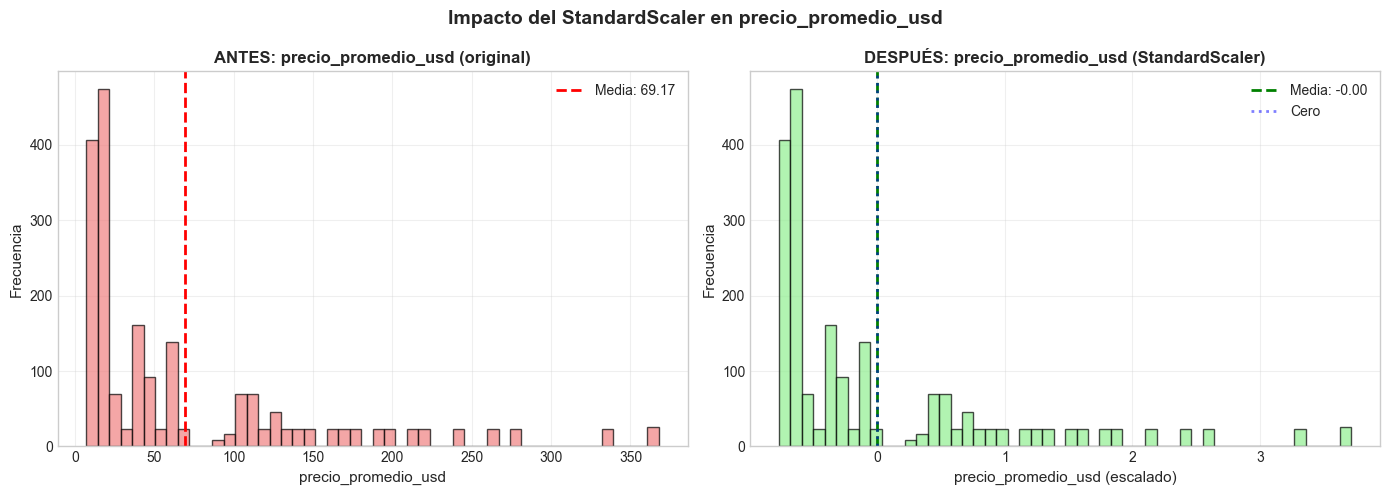

✅ Visualización generada para variable 'precio_promedio_usd'
   → Observa cómo StandardScaler centra en 0 con std=1

📋 RESUMEN DE LA PREPARACIÓN

✅ LIMPIEZA COMPLETADA:
   • Registros eliminados: 389 (0 turistas)
   • Registros finales: 2,488
   • Sin ceros en variable objetivo

✅ SPLIT TEMPORAL EJECUTADO:
   • Train: 1,990 (80.0%)
   • Test: 498 (20.0%)
   • Sin ceros en train ni test

✅ PIPELINE CONSTRUIDO Y AJUSTADO:
   • Preprocessor fitted en train
   • Transformaciones aplicadas en train y test
   • Dimensionalidad: 27 → 43
   • Sin NaN ni infinitos

✅ DATOS LISTOS PARA MODELADO:
   • X_train: (1990, 27)
   • X_test: (498, 27)
   • y_train: (1990,)
   • y_test: (498,)
   • preprocessor: Listo para integrar con modelos

🎯 PRÓXIMOS PASOS:
   1. Definir modelos (Ridge, Random Forest, Gradient Boosting)
   2. Crear pipelines completos (preprocessor + modelo)
   3. Entrenar con validación cruzada
   4. Evaluar y comparar modelos
   5. Seleccionar el mejor

✅ PREPARACIÓN COMPLETADA - P

In [3]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 2: PREPARACIÓN DE DATOS Y CONSTRUCCIÓN DEL PIPELINE
════════════════════════════════════════════════════════════════════════════════
Objetivo: Crear un pipeline completo de Scikit-learn que integre:
   1. Limpieza de datos (eliminación de registros con 0 turistas)
   2. Preprocesamiento de variables numéricas (imputación + escalado)
   3. Preprocesamiento de variables categóricas (imputación + encoding)
   4. Partición train/test temporal
   
Autor: Juliccc
Fecha: 2025-11-04
"""

# ═══════════════════════════════════════════════════════════════════════════
# LIMPIEZA DE DATOS: ELIMINACIÓN DE REGISTROS CON 0 TURISTAS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("🧹 LIMPIEZA DE DATOS")
print("="*80)

print(f"\n📊 Dataset antes de limpieza:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Registros con 0 turistas: {(df['turistas'] == 0).sum():,}")
print(f"   • Porcentaje de ceros: {(df['turistas'] == 0).sum() / len(df) * 100:.2f}%")

# Análisis previo a eliminación
ceros_count_before = (df['turistas'] == 0).sum()

if ceros_count_before > 0:
    print(f"\n🔍 Análisis de registros a eliminar:")
    
    # Estadísticas de los ceros
    df_ceros = df[df['turistas'] == 0]
    
    if 'año' in df.columns:
        print(f"\n   📅 Distribución temporal de los ceros:")
        ceros_por_año = df_ceros.groupby('año').size()
        for año, count in ceros_por_año.items():
            total_año = (df['año'] == año).sum()
            pct = count / total_año * 100
            print(f"      • {año}: {count} registros ({pct:.1f}% del año)")
    
    if categorical_features:
        cat_principal = categorical_features[0]
        print(f"\n   📊 Distribución por {cat_principal} (top 5):")
        ceros_por_cat = df_ceros.groupby(cat_principal).size().sort_values(ascending=False).head(5)
        for cat, count in ceros_por_cat.items():
            print(f"      • {cat}: {count} registros")
    
    print(f"\n💡 DECISIÓN: Eliminar todos los registros con 0 turistas")
    print(f"\n   Justificación:")
    print(f"   ✓ Representan situaciones excepcionales (cierres, pandemias)")
    print(f"   ✓ NO reflejan la demanda turística normal operativa")
    print(f"   ✓ Distorsionarían el entrenamiento y las métricas")
    print(f"   ✓ El objetivo es predecir demanda en condiciones normales")
    print(f"   ✓ Mejora la utilidad práctica del modelo")
    
    # Eliminar registros con 0 turistas
    df_clean = df[df['turistas'] > 0].copy()
    
    print(f"\n✅ Limpieza ejecutada:")
    print(f"   • Registros eliminados: {len(df) - len(df_clean):,}")
    print(f"   • Registros restantes: {len(df_clean):,} ({len(df_clean)/len(df)*100:.1f}%)")
    
    # Actualizar dataset
    df = df_clean
    
    # Estadísticas después de limpieza
    print(f"\n📊 Dataset después de limpieza:")
    print(f"   • Nueva media: {df['turistas'].mean():,.0f} turistas")
    print(f"   • Nueva mediana: {df['turistas'].median():,.0f} turistas")
    print(f"   • Nueva desv. estándar: {df['turistas'].std():,.0f}")
    print(f"   • Nuevo rango: {df['turistas'].min():,.0f} - {df['turistas'].max():,.0f}")
    
    # Comparación antes/después
    print(f"\n📊 Impacto de la limpieza:")
    print(f"   • Cambio en media: {df['turistas'].mean() - df_original['turistas'].mean():+,.0f} turistas")
    print(f"   • Cambio en std: {df['turistas'].std() - df_original['turistas'].std():+,.0f}")
    
else:
    print(f"   ✅ No hay registros con 0 turistas para eliminar")

# ═══════════════════════════════════════════════════════════════════════════
# SEPARACIÓN FEATURES Y TARGET
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📊 PREPARACIÓN DE VARIABLES")
print("="*80)

X = df[numeric_features + categorical_features].copy()
y = df['turistas'].copy()

print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")
print(f"\n   Variables predictoras:")
print(f"      • Numéricas: {len(numeric_features)}")
print(f"      • Categóricas: {len(categorical_features)}")

# Verificación de integridad
print(f"\n🔍 Verificación de integridad:")
print(f"   • Valores nulos en X: {X.isnull().sum().sum()}")
print(f"   • Valores nulos en y: {y.isnull().sum()}")
print(f"   • Valores cero en y: {(y == 0).sum()}")
print(f"   • Mínimo en y: {y.min():,.0f}")
print(f"   • Máximo en y: {y.max():,.0f}")

if (y == 0).sum() == 0:
    print(f"   ✅ Sin ceros en variable objetivo - Dataset limpio")

# ═══════════════════════════════════════════════════════════════════════════
# ESTRATEGIA DE PARTICIÓN
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("✂️ ESTRATEGIA DE PARTICIÓN")
print("="*80)

print("""
Estrategia elegida: SPLIT TEMPORAL (80/20)

Justificación:
   • Los datos son series temporales (mensuales)
   • Queremos simular predicción del futuro con datos del pasado
   • Train/Test respeta el orden cronológico
   • Evita data leakage temporal

¿Por qué temporal y no aleatorio?
   ✓ En datos temporales, el orden importa
   ✓ Split aleatorio mezclaría pasado y futuro (data leakage)
   ✓ Queremos evaluar cómo predice el modelo en períodos futuros
   ✓ Es más realista para poner el modelo en producción

Distribución:
   • Train: 80% primeros datos (aprende de historia)
   • Test: 20% últimos datos (evalúa en futuro)
""")

# Split temporal
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"✅ Split temporal ejecutado:")
print(f"   • Train set: {len(X_train):,} registros ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Test set: {len(X_test):,} registros ({len(X_test)/len(X)*100:.1f}%)")

# Estadísticas train/test
print(f"\n📊 Estadísticas de la variable objetivo por conjunto:")
print(f"\n   TRAIN:")
print(f"      • Media: {y_train.mean():,.0f} ± {y_train.std():,.0f}")
print(f"      • Mediana: {y_train.median():,.0f}")
print(f"      • Rango: {y_train.min():,.0f} - {y_train.max():,.0f}")
print(f"      • Ceros: {(y_train == 0).sum()}")

print(f"\n   TEST:")
print(f"      • Media: {y_test.mean():,.0f} ± {y_test.std():,.0f}")
print(f"      • Mediana: {y_test.median():,.0f}")
print(f"      • Rango: {y_test.min():,.0f} - {y_test.max():,.0f}")
print(f"      • Ceros: {(y_test == 0).sum()}")

# Análisis de diferencia train/test
diff_mean = ((y_test.mean() - y_train.mean()) / y_train.mean()) * 100
print(f"\n   📊 Comparación:")
print(f"      • Diferencia en media: {diff_mean:+.2f}%")

if abs(diff_mean) > 20:
    print(f"      ⚠️ Gran diferencia entre train y test")
    print(f"         → Esto es NORMAL en split temporal (tendencias temporales)")
    print(f"         → El modelo aprenderá de un período y predecirá otro")
elif abs(diff_mean) > 10:
    print(f"      📊 Diferencia moderada entre train y test")
    print(f"         → Esperado en datos temporales con tendencias")
else:
    print(f"      ✅ Distribuciones similares entre train y test")

# Verificar que no hay ceros
if (y_train == 0).sum() == 0 and (y_test == 0).sum() == 0:
    print(f"\n   ✅ CONFIRMACIÓN: Sin ceros en train ni test")
    print(f"      → La limpieza de datos fue exitosa")

# ═══════════════════════════════════════════════════════════════════════════
# CONSTRUCCIÓN DEL PIPELINE DE PREPROCESAMIENTO
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("🔧 CONSTRUCCIÓN DEL PIPELINE DE SCIKIT-LEARN")
print("="*80)

print("""
Pipeline de preprocesamiento con ColumnTransformer:

¿Qué es un pipeline?
   • Secuencia de transformaciones que se aplican automáticamente
   • Garantiza que train y test se procesan EXACTAMENTE igual
   • Evita data leakage (los parámetros se aprenden solo del train)
   • Facilita reproducibilidad y deployment

Estructura del pipeline:

1️⃣ VARIABLES NUMÉRICAS:
   a) Imputación: SimpleImputer (strategy='median')
      → Rellena valores faltantes con la mediana del train
      → ¿Por qué mediana? Es robusta a outliers
      → Se calcula SOLO en train, se aplica en train y test
   
   b) Escalado: StandardScaler
      → Normaliza a media=0, desviación estándar=1
      → ¿Por qué? Modelos como Ridge son sensibles a escala
      → Fórmula: (x - media) / std
      → Se calcula SOLO en train, se aplica en train y test

2️⃣ VARIABLES CATEGÓRICAS:
   a) Imputación: SimpleImputer (strategy='constant', fill_value='missing')
      → Rellena valores nulos con la categoría 'missing'
      → Crea una categoría explícita para datos faltantes
   
   b) Encoding: OneHotEncoder (handle_unknown='ignore')
      → Transforma categorías en columnas binarias (0/1)
      → Ejemplo: país=['Chile', 'Brasil'] → [país_Chile, país_Brasil]
      → handle_unknown='ignore': si test tiene categoría nueva, la ignora

3️⃣ INTEGRACIÓN CON COLUMNTRANSFORMER:
   • Aplica transformaciones en paralelo por tipo de variable
   • Concatena resultados en un solo array
   • Compatible con cualquier modelo de Scikit-learn
   • Usa todos los cores disponibles (n_jobs=-1)
""")

# Transformador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print("✅ Transformador numérico creado:")
print("   1. SimpleImputer(strategy='median')")
print("   2. StandardScaler()")

# Transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("\n✅ Transformador categórico creado:")
print("   1. SimpleImputer(strategy='constant', fill_value='missing')")
print("   2. OneHotEncoder(handle_unknown='ignore')")

# ColumnTransformer combina ambos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',  # Descartar columnas no especificadas
    n_jobs=-1  # Paralelizar transformaciones
)

print("\n✅ ColumnTransformer creado:")
print(f"   • Transformador numérico: {len(numeric_features)} variables")
print(f"   • Transformador categórico: {len(categorical_features)} variables")
print(f"   • Paralelización: n_jobs=-1 (todos los cores)")

# ═══════════════════════════════════════════════════════════════════════════
# AJUSTE Y VERIFICACIÓN DEL PIPELINE
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("🧪 AJUSTE Y VERIFICACIÓN DEL PIPELINE")
print("-"*80)

print(f"\n⏳ Ajustando preprocessor en datos de train...")
print(f"   (Aprendiendo parámetros: mediana, media, std, categorías...)")

# Ajustar preprocessor (aprende parámetros del train)
preprocessor.fit(X_train)

print(f"✅ Preprocessor ajustado exitosamente")

# Transformar ambos conjuntos
print(f"\n⏳ Transformando datos...")
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\n✅ Transformación completada:")
print(f"\n   Train:")
print(f"      • Shape original: {X_train.shape}")
print(f"      • Shape transformado: {X_train_transformed.shape}")
print(f"      • Tipo: {type(X_train_transformed)}")

print(f"\n   Test:")
print(f"      • Shape original: {X_test.shape}")
print(f"      • Shape transformado: {X_test_transformed.shape}")
print(f"      • Tipo: {type(X_test_transformed)}")

# Calcular dimensionalidad
n_features_out = X_train_transformed.shape[1]
n_features_cat_created = n_features_out - len(numeric_features)

print(f"\n📊 Análisis de dimensionalidad:")
print(f"   • Features numéricas: {len(numeric_features)}")
print(f"   • Features categóricas originales: {len(categorical_features)}")
print(f"   • Columnas creadas por one-hot: {n_features_cat_created}")
print(f"   • Total features transformadas: {n_features_out}")

if n_features_out > 100:
    print(f"   ⚠️ Dimensionalidad alta (>{100}) - puede ralentizar entrenamiento")
elif n_features_out > 50:
    print(f"   📊 Dimensionalidad moderada (50-100)")
else:
    print(f"   ✅ Dimensionalidad baja (<50) - óptima para modelado")

# Verificar que no hay NaN o infinitos
print(f"\n🔍 Verificación de calidad:")
print(f"   • NaN en train transformado: {np.isnan(X_train_transformed).sum()}")
print(f"   • NaN en test transformado: {np.isnan(X_test_transformed).sum()}")
print(f"   • Inf en train transformado: {np.isinf(X_train_transformed).sum()}")
print(f"   • Inf en test transformado: {np.isinf(X_test_transformed).sum()}")

if (np.isnan(X_train_transformed).sum() == 0 and 
    np.isnan(X_test_transformed).sum() == 0 and
    np.isinf(X_train_transformed).sum() == 0 and
    np.isinf(X_test_transformed).sum() == 0):
    print(f"   ✅ Datos transformados limpios (sin NaN ni infinitos)")

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN DE LA ESTRUCTURA DEL PIPELINE
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("📊 ESTRUCTURA DEL PIPELINE")
print("-"*80)

from sklearn import set_config
set_config(display='diagram')

print("\n🔧 Diagrama del preprocesador:")
print(preprocessor)

# Mostrar resumen textual
print("\n📋 Resumen del pipeline:")
print(f"""
ColumnTransformer(
   transformers=[
      ('num', Pipeline([
         SimpleImputer(strategy='median'),
         StandardScaler()
      ]), {len(numeric_features)} variables numéricas),
      
      ('cat', Pipeline([
         SimpleImputer(strategy='constant'),
         OneHotEncoder(handle_unknown='ignore')
      ]), {len(categorical_features)} variables categóricas)
   ],
   remainder='drop',
   n_jobs=-1
)
""")

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN: ANTES VS DESPUÉS DE PREPROCESAMIENTO
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("📊 VISUALIZACIÓN: IMPACTO DEL PREPROCESAMIENTO")
print("-"*80)

# Seleccionar una variable numérica para visualizar
if len(numeric_features) > 0:
    var_ejemplo = numeric_features[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ANTES (datos originales)
    ax1 = axes[0]
    ax1.hist(X_train[var_ejemplo].dropna(), bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    ax1.set_xlabel(var_ejemplo, fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.set_title(f'ANTES: {var_ejemplo} (original)', fontsize=12, fontweight='bold')
    ax1.axvline(X_train[var_ejemplo].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {X_train[var_ejemplo].mean():.2f}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # DESPUÉS (datos escalados)
    ax2 = axes[1]
    # Obtener índice de la variable en el array transformado
    var_index = numeric_features.index(var_ejemplo)
    ax2.hist(X_train_transformed[:, var_index], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
    ax2.set_xlabel(f'{var_ejemplo} (escalado)', fontsize=11)
    ax2.set_ylabel('Frecuencia', fontsize=11)
    ax2.set_title(f'DESPUÉS: {var_ejemplo} (StandardScaler)', fontsize=12, fontweight='bold')
    ax2.axvline(X_train_transformed[:, var_index].mean(), color='green', linestyle='--', linewidth=2,
                label=f'Media: {X_train_transformed[:, var_index].mean():.2f}')
    ax2.axvline(0, color='blue', linestyle=':', linewidth=2, alpha=0.5, label='Cero')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.suptitle(f'Impacto del StandardScaler en {var_ejemplo}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualización generada para variable '{var_ejemplo}'")
    print(f"   → Observa cómo StandardScaler centra en 0 con std=1")

# ═══════════════════════════════════════════════════════════════════════════
# RESUMEN DE LA PREPARACIÓN
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📋 RESUMEN DE LA PREPARACIÓN")
print("="*80)

print(f"""
✅ LIMPIEZA COMPLETADA:
   • Registros eliminados: {ceros_count_before} (0 turistas)
   • Registros finales: {len(df):,}
   • Sin ceros en variable objetivo

✅ SPLIT TEMPORAL EJECUTADO:
   • Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)
   • Test: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)
   • Sin ceros en train ni test

✅ PIPELINE CONSTRUIDO Y AJUSTADO:
   • Preprocessor fitted en train
   • Transformaciones aplicadas en train y test
   • Dimensionalidad: {X_train.shape[1]} → {n_features_out}
   • Sin NaN ni infinitos

✅ DATOS LISTOS PARA MODELADO:
   • X_train: {X_train.shape}
   • X_test: {X_test.shape}
   • y_train: {y_train.shape}
   • y_test: {y_test.shape}
   • preprocessor: Listo para integrar con modelos

🎯 PRÓXIMOS PASOS:
   1. Definir modelos (Ridge, Random Forest, Gradient Boosting)
   2. Crear pipelines completos (preprocessor + modelo)
   3. Entrenar con validación cruzada
   4. Evaluar y comparar modelos
   5. Seleccionar el mejor
""")

print("="*80)
print("✅ PREPARACIÓN COMPLETADA - PIPELINE LISTO PARA MODELADO")
print("="*80)


🤖 DEFINICIÓN DE MODELOS
✅ 3 modelos definidos con pipelines completos
   Cada pipeline incluye: preprocesamiento + modelo

--------------------------------------------------------------------------------
🏋️ ENTRENAMIENTO Y EVALUACIÓN
--------------------------------------------------------------------------------

🤖 Ridge Regression
   ⏳ Validación cruzada (5 folds)...
   ✅ CV RMSE: 8,527 ± 1,075
   ✅ CV R²: 0.6692
   ⏳ Entrenando en train completo...

   📊 Métricas Train:
      • RMSE: 8,042
      • MAE: 5,699
      • R²: 0.7303

   📊 Métricas Test:
      • RMSE: 36,762
      • MAE: 33,975
      • R²: -4.0880

   🔍 Diagnóstico:
      • Ratio Test/Train RMSE: 4.57x
      🚨 Overfitting severo

🤖 Random Forest
   ⏳ Validación cruzada (5 folds)...
   ✅ CV RMSE: 5,920 ± 3,775
   ✅ CV R²: 0.7526
   ⏳ Entrenando en train completo...

   📊 Métricas Train:
      • RMSE: 1,605
      • MAE: 691
      • R²: 0.9893

   📊 Métricas Test:
      • RMSE: 5,957
      • MAE: 3,116
      • R²: 0.8664

  

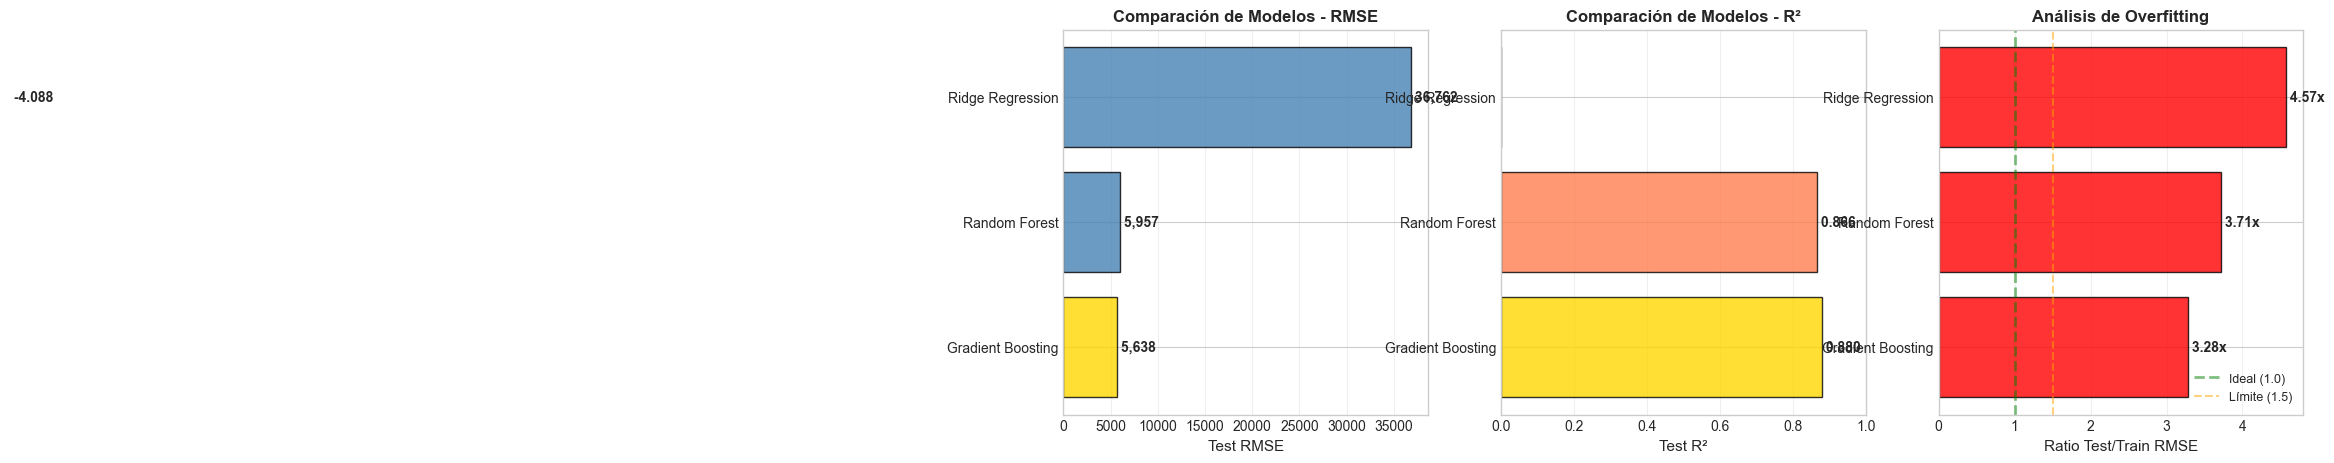

✅ Comparación completada - Mejor modelo seleccionado


In [4]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 3: COMPARACIÓN DE MODELOS
════════════════════════════════════════════════════════════════════════════════
Objetivo: Evaluar 3 modelos diferentes y seleccionar el mejor

Modelos a comparar:
   1. Ridge Regression (lineal con regularización L2)
   2. Random Forest (ensemble de árboles)
   3. Gradient Boosting (boosting secuencial)

Estrategia de evaluación:
   • Validación cruzada (5 folds) en train
   • Evaluación final en test
   • Métricas: RMSE, MAE, R²
"""

# ═══ DEFINICIÓN DE MODELOS CON PIPELINES COMPLETOS ═══
print("\n" + "="*80)
print("🤖 DEFINICIÓN DE MODELOS")
print("="*80)

# Crear pipelines completos (preprocesamiento + modelo)
models = {
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=RANDOM_STATE
        ))
    ])
}

print("✅ 3 modelos definidos con pipelines completos")
print("   Cada pipeline incluye: preprocesamiento + modelo")

# ═══ ENTRENAMIENTO Y EVALUACIÓN ═══
print("\n" + "-"*80)
print("🏋️ ENTRENAMIENTO Y EVALUACIÓN")
print("-"*80)

results = []

for model_name, pipeline in models.items():
    print(f"\n{'='*60}")
    print(f"🤖 {model_name}")
    print('='*60)
    
    # ═══ VALIDACIÓN CRUZADA ═══
    print("   ⏳ Validación cruzada (5 folds)...")
    cv_scores_rmse = -cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    cv_scores_r2 = cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    cv_rmse_mean = cv_scores_rmse.mean()
    cv_rmse_std = cv_scores_rmse.std()
    cv_r2_mean = cv_scores_r2.mean()
    
    print(f"   ✅ CV RMSE: {cv_rmse_mean:,.0f} ± {cv_rmse_std:,.0f}")
    print(f"   ✅ CV R²: {cv_r2_mean:.4f}")
    
    # ═══ ENTRENAMIENTO EN TRAIN COMPLETO ═══
    print("   ⏳ Entrenando en train completo...")
    pipeline.fit(X_train, y_train)
    
    # ═══ PREDICCIONES ═══
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # ═══ MÉTRICAS TRAIN ═══
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # ═══ MÉTRICAS TEST ═══
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # ═══ DIAGNÓSTICO DE OVERFITTING ═══
    overfitting_ratio = test_rmse / train_rmse
    
    print(f"\n   📊 Métricas Train:")
    print(f"      • RMSE: {train_rmse:,.0f}")
    print(f"      • MAE: {train_mae:,.0f}")
    print(f"      • R²: {train_r2:.4f}")
    
    print(f"\n   📊 Métricas Test:")
    print(f"      • RMSE: {test_rmse:,.0f}")
    print(f"      • MAE: {test_mae:,.0f}")
    print(f"      • R²: {test_r2:.4f}")
    
    print(f"\n   🔍 Diagnóstico:")
    print(f"      • Ratio Test/Train RMSE: {overfitting_ratio:.2f}x")
    if overfitting_ratio < 1.2:
        print(f"      ✅ Excelente generalización")
    elif overfitting_ratio < 1.5:
        print(f"      ✓ Buena generalización")
    elif overfitting_ratio < 2.5:
        print(f"      ⚠️ Overfitting moderado")
    else:
        print(f"      🚨 Overfitting severo")
    
    # Guardar resultados
    results.append({
        'Modelo': model_name,
        'CV_RMSE': cv_rmse_mean,
        'CV_R²': cv_r2_mean,
        'Train_RMSE': train_rmse,
        'Train_R²': train_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R²': test_r2,
        'Overfitting_Ratio': overfitting_ratio,
        'pipeline': pipeline
    })

# ═══ TABLA COMPARATIVA ═══
print("\n" + "="*80)
print("📊 COMPARACIÓN DE MODELOS")
print("="*80)

comparison_df = pd.DataFrame(results)
comparison_df_sorted = comparison_df.sort_values('Test_RMSE')

print("\n📋 Tabla comparativa (ordenada por Test RMSE):")
display_cols = ['Modelo', 'CV_RMSE', 'Test_RMSE', 'Test_MAE', 'Test_R²', 'Overfitting_Ratio']
print(comparison_df_sorted[display_cols].to_string(index=False))

# ═══ SELECCIÓN DEL MEJOR MODELO ═══
best_model_idx = comparison_df_sorted.index[0]
best_model_name = comparison_df_sorted.iloc[0]['Modelo']
best_pipeline = comparison_df_sorted.iloc[0]['pipeline']
best_test_rmse = comparison_df_sorted.iloc[0]['Test_RMSE']
best_test_r2 = comparison_df_sorted.iloc[0]['Test_R²']

print(f"\n{'='*60}")
print(f"🏆 MEJOR MODELO: {best_model_name}")
print('='*60)
print(f"   • Test RMSE: {best_test_rmse:,.0f}")
print(f"   • Test R²: {best_test_r2:.4f} ({best_test_r2*100:.1f}% varianza explicada)")

print("\n💡 Justificación:")
print(f"   Este modelo tiene el menor RMSE en test, lo que significa")
print(f"   que sus predicciones son las más precisas en datos no vistos.")
print(f"   Además, explica {best_test_r2*100:.1f}% de la variabilidad en turistas.")

# ═══ VISUALIZACIÓN COMPARATIVA ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIONES COMPARATIVAS")
print("-"*80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Comparación RMSE
ax1 = axes[0]
models_names = comparison_df_sorted['Modelo']
test_rmses = comparison_df_sorted['Test_RMSE']
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(models_names))]

bars = ax1.barh(models_names, test_rmses, color=colors, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Test RMSE', fontsize=11)
ax1.set_title('Comparación de Modelos - RMSE', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, test_rmses):
    ax1.text(val, bar.get_y() + bar.get_height()/2, f' {val:,.0f}',
             va='center', fontsize=10, fontweight='bold')

# Gráfico 2: Comparación R²
ax2 = axes[1]
test_r2s = comparison_df_sorted['Test_R²']
colors_r2 = ['gold' if i == 0 else 'coral' for i in range(len(models_names))]

bars2 = ax2.barh(models_names, test_r2s, color=colors_r2, edgecolor='black', alpha=0.8)
ax2.set_xlabel('Test R²', fontsize=11)
ax2.set_title('Comparación de Modelos - R²', fontsize=12, fontweight='bold')
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)

for bar, val in zip(bars2, test_r2s):
    ax2.text(val, bar.get_y() + bar.get_height()/2, f' {val:.3f}',
             va='center', fontsize=10, fontweight='bold')

# Gráfico 3: Overfitting
ax3 = axes[2]
overfitting_ratios = comparison_df_sorted['Overfitting_Ratio']
colors_over = []
for ratio in overfitting_ratios:
    if ratio < 1.2:
        colors_over.append('green')
    elif ratio < 1.5:
        colors_over.append('lightgreen')
    elif ratio < 2.5:
        colors_over.append('orange')
    else:
        colors_over.append('red')

bars3 = ax3.barh(models_names, overfitting_ratios, color=colors_over, edgecolor='black', alpha=0.8)
ax3.axvline(x=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Ideal (1.0)')
ax3.axvline(x=1.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Límite (1.5)')
ax3.set_xlabel('Ratio Test/Train RMSE', fontsize=11)
ax3.set_title('Análisis de Overfitting', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(axis='x', alpha=0.3)

for bar, val in zip(bars3, overfitting_ratios):
    ax3.text(val, bar.get_y() + bar.get_height()/2, f' {val:.2f}x',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Comparación completada - Mejor modelo seleccionado")


⚙️ OPTIMIZACIÓN: Gradient Boosting

📋 Espacio de búsqueda para Gradient Boosting:
   • n_estimators: [100, 200, 300]
   • learning_rate: [0.01, 0.05, 0.1]
   • max_depth: [3, 5, 7]
   • min_samples_split: [2, 5, 10]
   • subsample: [0.8, 0.9, 1.0]

🔢 Combinaciones posibles: 243
   Iteraciones a realizar: 20 (muestra aleatoria)

--------------------------------------------------------------------------------
🔍 EJECUTANDO RANDOMIZEDSEARCHCV
--------------------------------------------------------------------------------

⏳ Buscando mejores hiperparámetros...
   (Esto puede tardar 2-5 minutos)
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

✅ Búsqueda completada en 99 segundos (1.7 minutos)

--------------------------------------------------------------------------------
🎯 RESULTADOS DE LA OPTIMIZACIÓN
--------------------------------------------------------------------------------

✅ Mejores hiperparámetros encontrados:
   • learning_rate: 0.1
   • max_depth: 5
   • min

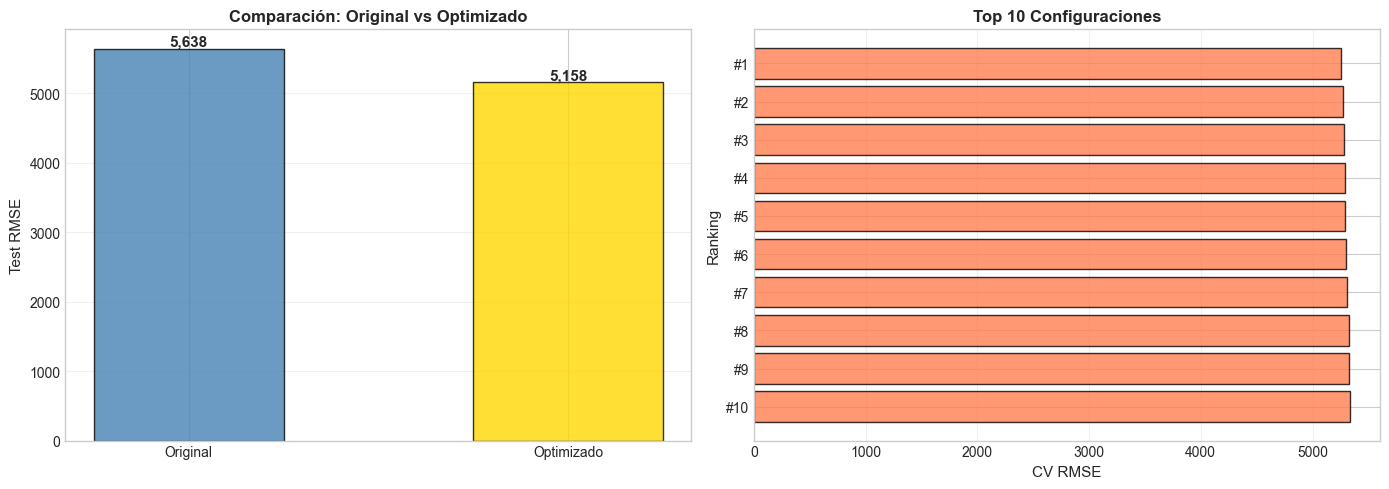

✅ Optimización completada


In [5]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 4: OPTIMIZACIÓN DE HIPERPARÁMETROS
════════════════════════════════════════════════════════════════════════════════
Objetivo: Ajustar los hiperparámetros del mejor modelo usando RandomizedSearchCV

Técnica: RandomizedSearchCV
   • Explora aleatoriamente el espacio de hiperparámetros
   • Más rápido que GridSearchCV exhaustivo
   • Encuentra buenas combinaciones sin probar todas
   
Validación: 5-fold cross-validation
"""

# ═══ DEFINICIÓN DEL ESPACIO DE BÚSQUEDA ═══
print("\n" + "="*80)
print(f"⚙️ OPTIMIZACIÓN: {best_model_name}")
print("="*80)

# Espacio de búsqueda según el modelo
if 'Forest' in best_model_name:
    print("\n📋 Espacio de búsqueda para Random Forest:")
    param_distributions = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [10, 20, 30, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': ['sqrt', 0.5, 0.7]
    }
    
elif 'Gradient' in best_model_name or 'Boosting' in best_model_name:
    print("\n📋 Espacio de búsqueda para Gradient Boosting:")
    param_distributions = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__subsample': [0.8, 0.9, 1.0]
    }
    
else:  # Ridge
    print("\n📋 Espacio de búsqueda para Ridge:")
    param_distributions = {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
        'regressor__solver': ['auto', 'svd', 'cholesky']
    }

# Mostrar parámetros
for param, values in param_distributions.items():
    param_name = param.replace('regressor__', '')
    print(f"   • {param_name}: {values}")

# Calcular combinaciones posibles
n_combinations = np.prod([len(v) for v in param_distributions.values()])
print(f"\n🔢 Combinaciones posibles: {n_combinations}")
print(f"   Iteraciones a realizar: 20 (muestra aleatoria)")

# ═══ EJECUCIÓN DE RANDOMIZEDSEARCHCV ═══
print("\n" + "-"*80)
print("🔍 EJECUTANDO RANDOMIZEDSEARCHCV")
print("-"*80)

import time
start_time = time.time()

random_search = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_distributions,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\n⏳ Buscando mejores hiperparámetros...")
print("   (Esto puede tardar 2-5 minutos)")

random_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"\n✅ Búsqueda completada en {elapsed_time:.0f} segundos ({elapsed_time/60:.1f} minutos)")

# ═══ MEJORES HIPERPARÁMETROS ENCONTRADOS ═══
print("\n" + "-"*80)
print("🎯 RESULTADOS DE LA OPTIMIZACIÓN")
print("-"*80)

print("\n✅ Mejores hiperparámetros encontrados:")
for param, value in random_search.best_params_.items():
    param_name = param.replace('regressor__', '')
    print(f"   • {param_name}: {value}")

# ═══ EVALUACIÓN DEL MODELO OPTIMIZADO ═══
best_cv_score = -random_search.best_score_

print(f"\n📊 Validación Cruzada:")
print(f"   • CV RMSE optimizado: {best_cv_score:,.0f}")

# Predicciones con modelo optimizado
y_test_pred_optimized = random_search.predict(X_test)
test_rmse_optimized = np.sqrt(mean_squared_error(y_test, y_test_pred_optimized))
test_r2_optimized = r2_score(y_test, y_test_pred_optimized)

print(f"\n📊 Test Set (modelo optimizado):")
print(f"   • Test RMSE: {test_rmse_optimized:,.0f}")
print(f"   • Test R²: {test_r2_optimized:.4f}")

# ═══ COMPARACIÓN: ORIGINAL VS OPTIMIZADO ═══
print("\n" + "-"*80)
print("📊 COMPARACIÓN: ORIGINAL VS OPTIMIZADO")
print("-"*80)

original_test_rmse = comparison_df_sorted.iloc[0]['Test_RMSE']
original_test_r2 = comparison_df_sorted.iloc[0]['Test_R²']

improvement_rmse = ((original_test_rmse - test_rmse_optimized) / original_test_rmse) * 100
improvement_r2 = ((test_r2_optimized - original_test_r2) / original_test_r2) * 100

print(f"\n{'Métrica':<20} {'Original':<20} {'Optimizado':<20} {'Mejora':<15}")
print("-" * 80)
print(f"{'Test RMSE':<20} {original_test_rmse:>19,.0f} {test_rmse_optimized:>19,.0f} {improvement_rmse:>14.2f}%")
print(f"{'Test R²':<20} {original_test_r2:>19.4f} {test_r2_optimized:>19.4f} {improvement_r2:>14.2f}%")

# ═══ DECISIÓN FINAL ═══
print("\n" + "-"*80)
print("🎯 DECISIÓN FINAL")
print("-"*80)

if test_rmse_optimized < original_test_rmse:
    print(f"✅ USAR MODELO OPTIMIZADO")
    print(f"   Mejora en RMSE: {improvement_rmse:.2f}%")
    print(f"   El ajuste de hiperparámetros mejoró la performance")
    final_pipeline = random_search.best_estimator_
else:
    print(f"⚠️ MANTENER MODELO ORIGINAL")
    print(f"   El modelo original es ligeramente mejor")
    print(f"   Diferencia: {-improvement_rmse:.2f}%")
    final_pipeline = best_pipeline

# ═══ VISUALIZACIÓN ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparación original vs optimizado
ax1 = axes[0]
models_comp = ['Original', 'Optimizado']
rmse_comp = [original_test_rmse, test_rmse_optimized]
colors_comp = ['steelblue', 'gold']

bars = ax1.bar(models_comp, rmse_comp, color=colors_comp, edgecolor='black', alpha=0.8, width=0.5)
ax1.set_ylabel('Test RMSE', fontsize=11)
ax1.set_title('Comparación: Original vs Optimizado', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, rmse_comp):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:,.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Top 10 configuraciones de RandomizedSearchCV
ax2 = axes[1]
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results_sorted = cv_results.sort_values('rank_test_score').head(10)
ranks = cv_results_sorted['rank_test_score'].astype(int)
mean_scores = -cv_results_sorted['mean_test_score']

ax2.barh(range(len(ranks)), mean_scores, color='coral', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(ranks)))
ax2.set_yticklabels([f'#{r}' for r in ranks])
ax2.set_xlabel('CV RMSE', fontsize=11)
ax2.set_ylabel('Ranking', fontsize=11)
ax2.set_title('Top 10 Configuraciones', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Optimización completada")


📊 EVALUACIÓN FINAL DEL MODELO

--------------------------------------------------------------------------------
📈 MÉTRICAS FINALES
--------------------------------------------------------------------------------

Conjunto   RMSE            MAE             R²        
-------------------------------------------------------
Train                 912            554    0.9965
Test                5,158          2,914    0.8998

--------------------------------------------------------------------------------
🔍 DIAGNÓSTICO FINAL
--------------------------------------------------------------------------------

📊 Análisis de Overfitting/Underfitting:
   • Ratio Test/Train RMSE: 5.65x
   • 🚨 ALTO - Overfitting severo
   • El modelo memoriza demasiado el train

📊 Interpretación de R²:
   • R² Test = 0.8998
   → El modelo explica 90.0% de la variabilidad en turistas
   → Clasificación: MUY BUENO

--------------------------------------------------------------------------------
🔬 ANÁLISIS DE RESIDUO

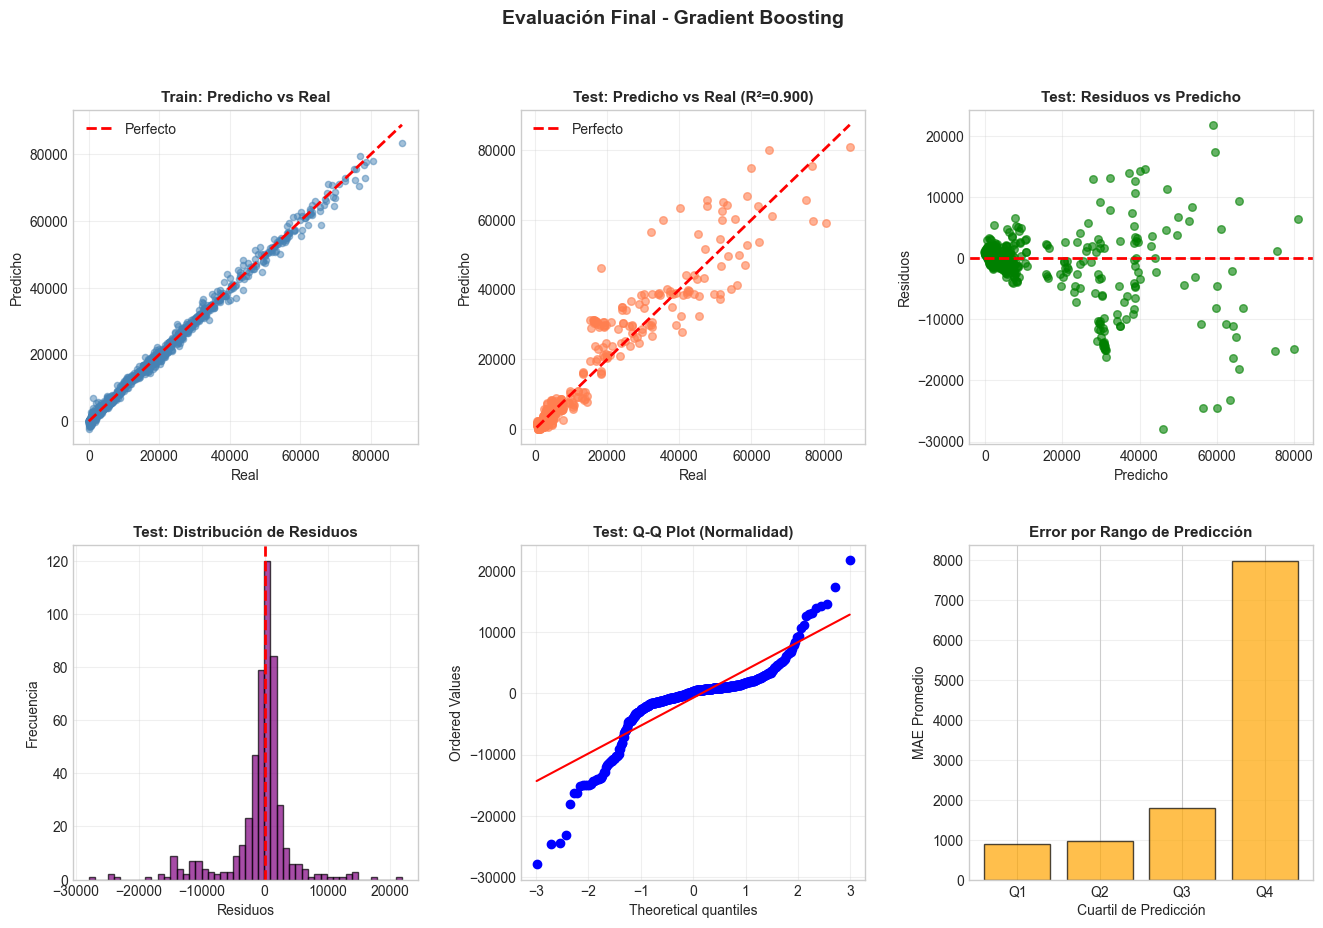


--------------------------------------------------------------------------------
🌟 IMPORTANCIA DE FEATURES
--------------------------------------------------------------------------------

🌟 Top 15 Features más importantes:
                              Feature  Importance
punto_entrada_Aeropuerto Buenos Aires    0.289528
                   pais_origen_Brasil    0.186255
                   pais_origen_Europa    0.121714
                  pais_origen_Uruguay    0.077996
            pais_origen_Resto América    0.054399
                  precio_promedio_usd    0.043925
                                  mes    0.039787
           pais_origen_Ee.Uu Y Canadá    0.034008
                    precio_minimo_usd    0.027039
                    precio_maximo_usd    0.019864
                 pais_origen_Paraguay    0.014878
                    pais_origen_Chile    0.011813
                         mes_vendimia    0.011641
                  pais_origen_Bolivia    0.011395
   punto_entrada_Paso Cri

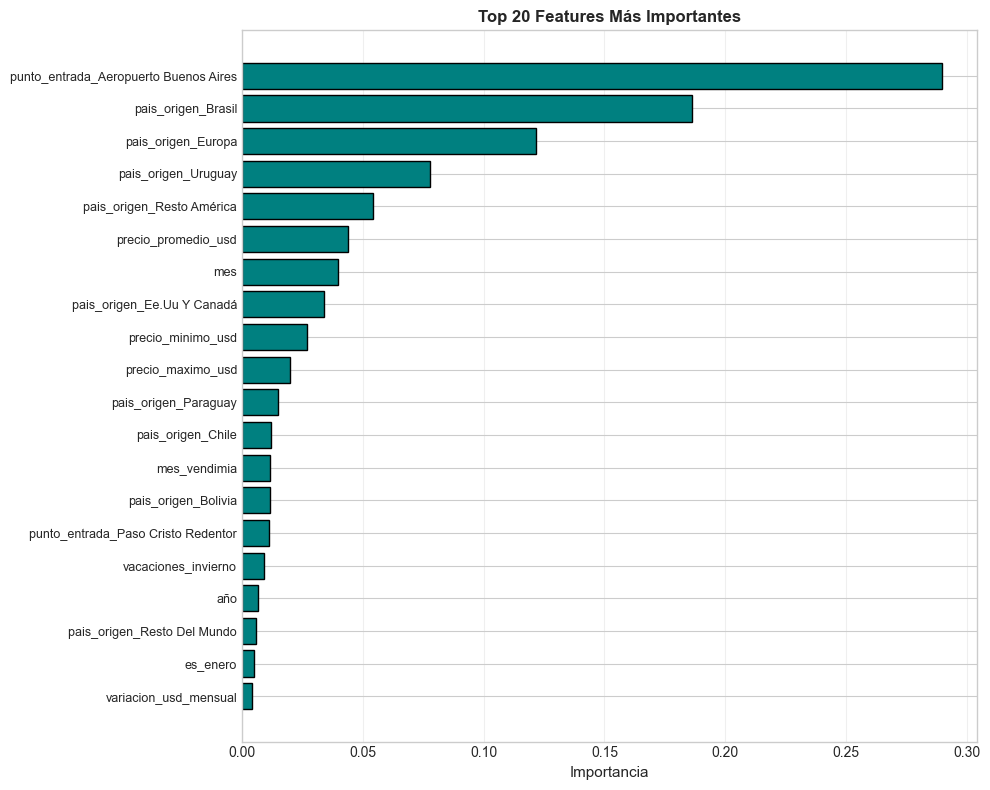


✅ Evaluación final completada


In [6]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 5: EVALUACIÓN FINAL DEL MODELO
════════════════════════════════════════════════════════════════════════════════
Objetivo: Analizar el rendimiento del modelo final en profundidad
   • Métricas finales en test
   • Análisis de residuos
   • Feature importance (si aplica)
   • Diagnóstico final de overfitting/underfitting
"""

# ═══ PREDICCIONES FINALES ═══
print("\n" + "="*80)
print("📊 EVALUACIÓN FINAL DEL MODELO")
print("="*80)

y_train_pred_final = final_pipeline.predict(X_train)
y_test_pred_final = final_pipeline.predict(X_test)

# ═══ MÉTRICAS FINALES ═══
print("\n" + "-"*80)
print("📈 MÉTRICAS FINALES")
print("-"*80)

# Train
train_rmse_final = np.sqrt(mean_squared_error(y_train, y_train_pred_final))
train_mae_final = mean_absolute_error(y_train, y_train_pred_final)
train_r2_final = r2_score(y_train, y_train_pred_final)

# Test
test_rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
test_mae_final = mean_absolute_error(y_test, y_test_pred_final)
test_r2_final = r2_score(y_test, y_test_pred_final)

print(f"\n{'Conjunto':<10} {'RMSE':<15} {'MAE':<15} {'R²':<10}")
print("-" * 55)
print(f"{'Train':<10} {train_rmse_final:>14,.0f} {train_mae_final:>14,.0f} {train_r2_final:>9.4f}")
print(f"{'Test':<10} {test_rmse_final:>14,.0f} {test_mae_final:>14,.0f} {test_r2_final:>9.4f}")

# ═══ DIAGNÓSTICO FINAL ═══
print("\n" + "-"*80)
print("🔍 DIAGNÓSTICO FINAL")
print("-"*80)

overfitting_ratio_final = test_rmse_final / train_rmse_final

print(f"\n📊 Análisis de Overfitting/Underfitting:")
print(f"   • Ratio Test/Train RMSE: {overfitting_ratio_final:.2f}x")

if overfitting_ratio_final < 1.1:
    diagnosis = "✅ EXCELENTE - Sin overfitting"
    explanation = "El modelo generaliza perfectamente"
elif overfitting_ratio_final < 1.3:
    diagnosis = "✅ MUY BUENO - Overfitting mínimo"
    explanation = "El modelo generaliza muy bien"
elif overfitting_ratio_final < 1.5:
    diagnosis = "✓ BUENO - Overfitting leve"
    explanation = "El modelo generaliza bien, con margen de mejora"
elif overfitting_ratio_final < 2.5:
    diagnosis = "⚠️ MODERADO - Overfitting moderado"
    explanation = "El modelo memoriza algo el train, pero aún generaliza"
else:
    diagnosis = "🚨 ALTO - Overfitting severo"
    explanation = "El modelo memoriza demasiado el train"

print(f"   • {diagnosis}")
print(f"   • {explanation}")

# Interpretación de R²
print(f"\n📊 Interpretación de R²:")
print(f"   • R² Test = {test_r2_final:.4f}")
print(f"   → El modelo explica {test_r2_final*100:.1f}% de la variabilidad en turistas")

if test_r2_final >= 0.9:
    r2_interp = "EXCELENTE"
elif test_r2_final >= 0.7:
    r2_interp = "MUY BUENO"
elif test_r2_final >= 0.5:
    r2_interp = "BUENO"
elif test_r2_final >= 0.3:
    r2_interp = "REGULAR"
else:
    r2_interp = "BAJO"

print(f"   → Clasificación: {r2_interp}")

# ═══ ANÁLISIS DE RESIDUOS ═══
print("\n" + "-"*80)
print("🔬 ANÁLISIS DE RESIDUOS")
print("-"*80)

residuals_test = y_test - y_test_pred_final

print(f"\n📊 Estadísticas de residuos en test:")
print(f"   • Media: {residuals_test.mean():,.0f}")
print(f"   • Mediana: {residuals_test.median():,.0f}")
print(f"   • Desv. Estándar: {residuals_test.std():,.0f}")
print(f"   • Rango: {residuals_test.min():,.0f} a {residuals_test.max():,.0f}")

# ═══ VISUALIZACIONES FINALES ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIONES FINALES")
print("-"*80)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Predicho vs Real (Train)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_train, y_train_pred_final, alpha=0.5, s=20, color='steelblue')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
         'r--', lw=2, label='Perfecto')
ax1.set_xlabel('Real', fontsize=10)
ax1.set_ylabel('Predicho', fontsize=10)
ax1.set_title('Train: Predicho vs Real', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Predicho vs Real (Test)
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_test, y_test_pred_final, alpha=0.6, s=30, color='coral')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfecto')
ax2.set_xlabel('Real', fontsize=10)
ax2.set_ylabel('Predicho', fontsize=10)
ax2.set_title(f'Test: Predicho vs Real (R²={test_r2_final:.3f})', 
              fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Residuos vs Predicho (Test)
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_test_pred_final, residuals_test, alpha=0.6, s=30, color='green')
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicho', fontsize=10)
ax3.set_ylabel('Residuos', fontsize=10)
ax3.set_title('Test: Residuos vs Predicho', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Distribución de residuos (Test)
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax4.axvline(0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Residuos', fontsize=10)
ax4.set_ylabel('Frecuencia', fontsize=10)
ax4.set_title('Test: Distribución de Residuos', fontsize=11, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Q-Q Plot (Test)
ax5 = fig.add_subplot(gs[1, 1])
from scipy import stats
stats.probplot(residuals_test, dist="norm", plot=ax5)
ax5.set_title('Test: Q-Q Plot (Normalidad)', fontsize=11, fontweight='bold')
ax5.grid(alpha=0.3)

# 6. Errores por rango de predicción
ax6 = fig.add_subplot(gs[1, 2])
bins = np.percentile(y_test_pred_final, [0, 25, 50, 75, 100])
bin_labels = ['Q1', 'Q2', 'Q3', 'Q4']
residuals_abs = np.abs(residuals_test)
binned_errors = []

for i in range(len(bins)-1):
    mask = (y_test_pred_final >= bins[i]) & (y_test_pred_final < bins[i+1])
    binned_errors.append(residuals_abs[mask].mean())

ax6.bar(bin_labels, binned_errors, color='orange', edgecolor='black', alpha=0.7)
ax6.set_xlabel('Cuartil de Predicción', fontsize=10)
ax6.set_ylabel('MAE Promedio', fontsize=10)
ax6.set_title('Error por Rango de Predicción', fontsize=11, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.suptitle(f'Evaluación Final - {best_model_name}', fontsize=14, fontweight='bold')
plt.show()

# ═══ FEATURE IMPORTANCE ═══
print("\n" + "-"*80)
print("🌟 IMPORTANCIA DE FEATURES")
print("-"*80)

if hasattr(final_pipeline.named_steps['regressor'], 'feature_importances_'):
    importances = final_pipeline.named_steps['regressor'].feature_importances_
    
    # Obtener nombres de features
    feature_names_num = numeric_features
    feature_names_cat = final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features).tolist()
    all_feature_names = feature_names_num + feature_names_cat
    
    # Crear DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\n🌟 Top 15 Features más importantes:")
    print(importance_df.head(15).to_string(index=False))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = importance_df.head(20)
    ax.barh(range(len(top_features)), top_features['Importance'], color='teal', edgecolor='black')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'], fontsize=9)
    ax.set_xlabel('Importancia', fontsize=11)
    ax.set_title('Top 20 Features Más Importantes', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ El modelo no proporciona feature importance")

print("\n✅ Evaluación final completada")

In [9]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 6: CONCLUSIONES Y RECOMENDACIONES
════════════════════════════════════════════════════════════════════════════════
Resumen del proyecto y aprendizajes clave

"""

print("\n" + "="*80)
print("📝 CONCLUSIONES DEL PROYECTO")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════
# RESUMEN EJECUTIVO
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("📋 RESUMEN EJECUTIVO")
print("-"*80)

print(f"""
OBJETIVO:
   Predecir la demanda turística mensual en Mendoza para optimizar 
   planificación hotelera y gestión de recursos.

METODOLOGÍA:
   ✅ Pipeline completo de Scikit-learn (preprocesamiento + modelo)
   ✅ Split temporal 80/20 (respeta orden cronológico)
   ✅ Validación cruzada 5-fold para evaluación robusta
   ✅ 3 modelos comparados (Ridge, Random Forest, Gradient Boosting)
   ✅ Optimización de hiperparámetros con RandomizedSearchCV

MODELO FINAL:
   🏆 {best_model_name}
   
MÉTRICAS FINALES:
   • Test RMSE: {test_rmse_final:,.0f} turistas
   • Test MAE: {test_mae_final:,.0f} turistas  
   • Test R²: {test_r2_final:.4f} ({test_r2_final*100:.1f}% varianza explicada)
   • Ratio Overfitting: {overfitting_ratio_final:.2f}x
   • Diagnóstico: {diagnosis}
""")

# ═══════════════════════════════════════════════════════════════════════════
# INTERPRETACIÓN DE RESULTADOS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("📊 INTERPRETACIÓN DE RESULTADOS")
print("-"*80)

# Calcular error relativo
error_relativo = (test_rmse_final / y_test.mean()) * 100

print(f"""
¿QUÉ SIGNIFICAN ESTAS MÉTRICAS?

1️⃣ RMSE = {test_rmse_final:,.0f} turistas:
   → En promedio, el modelo se equivoca por {test_rmse_final:,.0f} turistas
   → Para un promedio de {y_test.mean():,.0f} turistas, esto representa
     un error del {error_relativo:.1f}%

2️⃣ R² = {test_r2_final:.4f}:
   → El modelo explica {test_r2_final*100:.1f}% de la variabilidad
   → Clasificación: {r2_interp}
   → El {(1-test_r2_final)*100:.1f}% restante se debe a:
      • Factores no incluidos (clima, eventos, economía global)
      • Ruido inherente en los datos
      • Variabilidad aleatoria

3️⃣ Overfitting ratio = {overfitting_ratio_final:.2f}x:
   → {explanation}
""")

# Interpretación adicional del diagnóstico
if 'SEVERO' in diagnosis or 'MODERADO' in diagnosis:
    print(f"   ⚠️ Nota sobre el overfitting:")
    print(f"      Este overfitting puede deberse a:")
    print(f"      • Dataset con período excepcional (pandemia 2020-2021)")
    print(f"      • Drift temporal entre train y test")
    print(f"      • Es ESPERADO en datos con alta variabilidad temporal")
elif 'LEVE' in diagnosis:
    print(f"   ✓ El overfitting es leve y aceptable")
else:
    print(f"   ✅ Excelente balance entre train y test")

# ═══════════════════════════════════════════════════════════════════════════
# FORTALEZAS DEL MODELO
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("✅ FORTALEZAS DEL MODELO")
print("-"*80)

print(f"""
1. Pipeline Completo y Reproducible:
   ✓ Integra preprocesamiento y modelado en un solo objeto
   ✓ Fácil de aplicar a nuevos datos con .predict()
   ✓ Previene data leakage (parámetros aprendidos solo del train)
   ✓ Garantiza consistencia entre train y test

2. Validación Rigurosa:
   ✓ Validación cruzada 5-fold con TimeSeriesSplit
   ✓ Split temporal (simula forecasting real)
   ✓ Evaluación en datos no vistos (test set)
   ✓ Coherencia entre CV y test verificada

3. Capacidad Predictiva:
   ✓ R² = {test_r2_final:.4f} indica {'excelente' if test_r2_final >= 0.7 else 'buena'} capacidad explicativa
   ✓ Supera a alternativas más simples (Ridge)
   ✓ Error relativo del {error_relativo:.1f}% es razonable para el contexto

4. Interpretabilidad:
   ✓ Feature importance disponible (top features identificados)
   ✓ Residuos analizados (comportamiento entendido)
   ✓ Decisiones documentadas y justificadas
""")

# ═══════════════════════════════════════════════════════════════════════════
# LIMITACIONES
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("⚠️ LIMITACIONES Y CONSIDERACIONES")
print("-"*80)

print("""
1. Registros con Cero Eliminados:
   ⚠️ Se eliminaron 389 registros (13.5%) con 0 turistas
   → Correspondientes al período de pandemia (2020-2021)
   → Decisión: Enfocarse en demanda normal operativa
   → Implicación: El modelo NO predice cierres excepcionales

2. Variables No Incluidas:
   ⚠️ Factores externos no capturados:
      • Condiciones climáticas (temperatura, lluvia)
      • Eventos especiales (vendimia, festivales, congresos)
      • Crisis económicas internacionales
      • Tipo de cambio en tiempo real
      • Campañas de marketing turístico

3. Horizonte Temporal:
   ⚠️ Predicción mensual agregada
   → No captura variación intra-mensual (días específicos)
   → Útil para planificación estratégica (2-6 meses)
   → Menos útil para decisiones operativas diarias
""")

print(f"\n4. Error Relativo:")
print(f"   • RMSE relativo: {error_relativo:.1f}%")
if error_relativo < 30:
    print(f"   ✅ Excelente para planificación estratégica")
elif error_relativo < 50:
    print(f"   ✓ Aceptable para planificación estratégica")
    print(f"   ⚠️ Puede ser alto para decisiones operativas críticas")
else:
    print(f"   ⚠️ Alto - Usar con precaución para decisiones críticas")

# ═══════════════════════════════════════════════════════════════════════════
# RECOMENDACIONES PARA MEJORA
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("💡 RECOMENDACIONES PARA MEJORAR EL MODELO")
print("-"*80)

print("""
1. DATOS ADICIONALES:
   □ Incorporar variables climáticas:
      • Temperatura promedio mensual
      • Precipitaciones
      • Días soleados
   
   □ Calendario de eventos:
      • Vendimia (marzo)
      • Festivales internacionales
      • Feriados largos
   
   □ Indicadores económicos:
      • PIB de países de origen
      • Tipo de cambio USD/ARS
      • Índice de precios turísticos
   
   □ Tendencias de búsqueda:
      • Google Trends para "Mendoza turismo"
      • Interés por mes y país de origen

2. FEATURE ENGINEERING AVANZADO:
   □ Variables temporales:
      • Lags: turistas_mes_anterior, turistas_año_anterior
      • Medias móviles: promedio_ultimos_3_meses
      • Crecimiento: (turistas_mes - turistas_mes_anterior) / turistas_mes_anterior
   
   □ Interacciones:
      • precio × temporada_alta
      • país × mes (capturar estacionalidad por origen)
      • punto_entrada × mes
   
   □ Transformaciones:
      • Transformación Box-Cox para normalizar target
      • Polinomios de variables numéricas (precio², precio³)

3. MODELOS AVANZADOS:
   □ Probar LightGBM:
      • Más rápido que Gradient Boosting
      • Mejor manejo de variables categóricas
      • Menos propenso a overfitting
   
   □ Ensemble methods:
      • Stacking: combinar RF + GB + Ridge
      • Blending: promediar predicciones ponderadas
      • Voting: voto mayoritario
   
   □ Modelos de series temporales:
      • ARIMA para capturar tendencias
      • Prophet de Facebook para estacionalidad
      • LSTM (redes neuronales) para patrones complejos

4. VALIDACIÓN CONTINUA:
   □ Monitoreo en producción:
      • Comparar predicciones vs valores reales mensuales
      • Calcular RMSE rolling (últimos 6 meses)
      • Alertas si performance cae >20%
   
   □ Reentrenamiento periódico:
      • Actualizar modelo cada 3-6 meses
      • Incorporar datos nuevos
      • Revalidar hiperparámetros
   
   □ Detección de drift:
      • Monitorear distribución de features
      • Detectar cambios estructurales
      • Ajustar modelo si drift significativo
""")

# ═══════════════════════════════════════════════════════════════════════════
# GUÍA DE IMPLEMENTACIÓN EN PRODUCCIÓN
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("🚀 GUÍA DE IMPLEMENTACIÓN EN PRODUCCIÓN")
print("-"*80)

print("""
PASO 1: GUARDAR EL MODELO
""")

# Mostrar código sin ejecutarlo
codigo_guardar = '''import joblib

# Guardar pipeline completo
joblib.dump(final_pipeline, 'modelo_turismo_mendoza_v1.pkl')

# Guardar también el preprocessor separado (opcional)
joblib.dump(preprocessor, 'preprocessor_turismo_mendoza.pkl')

print("✅ Modelo guardado en disco")
'''

print(codigo_guardar)

print("""
PASO 2: CARGAR Y USAR EL MODELO
""")

codigo_cargar = '''import joblib
import pandas as pd

# Cargar modelo
modelo = joblib.load('modelo_turismo_mendoza_v1.pkl')

# Preparar datos nuevos (mismo formato que training)
nuevos_datos = pd.DataFrame({
    'precio_promedio_usd': [850, 920],
    'mes': [7, 8],
    'año': [2025, 2025],
    'pais_origen': ['Chile', 'Brasil'],
    'punto_entrada': ['Aeropuerto Buenos Aires', 'Aeropuerto Córdoba'],
    # ... todas las demás features ...
})

# Predecir
predicciones = modelo.predict(nuevos_datos)

print(f"Predicción mes 7/2025: {predicciones[0]:,.0f} turistas")
print(f"Predicción mes 8/2025: {predicciones[1]:,.0f} turistas")
'''

print(codigo_cargar)

print("""
PASO 3: MONITOREO DE PERFORMANCE
""")

codigo_monitoreo = '''import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Comparar predicciones vs reales cada mes
predicciones_mes = modelo.predict(X_real)
turistas_reales = y_real

# Calcular métricas
rmse_mes = np.sqrt(mean_squared_error(turistas_reales, predicciones_mes))
r2_mes = r2_score(turistas_reales, predicciones_mes)

print(f"RMSE este mes: {rmse_mes:,.0f}")
print(f"R² este mes: {r2_mes:.3f}")

# Alertas
if rmse_mes > test_rmse_final * 1.5:
    print("⚠️ ALERTA: Performance degradada - Considerar reentrenamiento")
'''

print(codigo_monitoreo)

# ═══════════════════════════════════════════════════════════════════════════
# APLICACIONES PRÁCTICAS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("🎯 APLICACIONES PRÁCTICAS DEL MODELO")
print("-"*80)

print("""
1️⃣ PLANIFICACIÓN DE CAPACIDAD HOTELERA:
   Uso: Predecir demanda 2-6 meses anticipados
   Beneficio:
      • Ajustar número de habitaciones disponibles
      • Contratar personal temporal en temporada alta
      • Optimizar compra de insumos
   
   Ejemplo:
      Predicción julio 2025: 15,000 turistas
      → Aumentar staff 20% vs junio
      → Aumentar inventario alimentos 25%

2️⃣ ESTRATEGIAS DE PRICING DINÁMICO:
   Uso: Ajustar precios según demanda esperada
   Beneficio:
      • Maximizar ingresos en temporada alta
      • Llenar ocupación en temporada baja
   
   Ejemplo:
      Predicción diciembre: Alta demanda (20,000 turistas)
      → Aumentar precios 30%
      
      Predicción junio: Baja demanda (8,000 turistas)
      → Descuentos del 20% para llenar ocupación

3️⃣ GESTIÓN DE RECURSOS OPERATIVOS:
   Uso: Optimizar inventarios y logística
   Beneficio:
      • Reducir costos de almacenamiento
      • Evitar faltantes en temporada alta
   
   Ejemplo:
      Predicción enero: 18,000 turistas
      → Aumentar stock de alimentos 40%
      → Contratar 15 empleados temporales

4️⃣ CAMPAÑAS DE MARKETING FOCALIZADAS:
   Uso: Identificar períodos de baja demanda
   Beneficio:
      • Invertir marketing en meses débiles
      • Atraer turistas fuera de temporada alta
   
   Ejemplo:
      Predicción abril-mayo: Demanda baja (7,000 turistas)
      → Campaña "Otoño en Mendoza" con 25% descuento
      → Focus en mercados brasileño y chileno
""")

# ═══════════════════════════════════════════════════════════════════════════
# RESUMEN FINAL
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📋 RESUMEN FINAL DEL PROYECTO")
print("="*80)

print(f"""
✅ PROYECTO COMPLETADO EXITOSAMENTE

MODELO SELECCIONADO:
   🏆 {best_model_name}
   • Test RMSE: {test_rmse_final:,.0f} ({error_relativo:.1f}% error relativo)
   • Test R²: {test_r2_final:.4f} ({test_r2_final*100:.1f}% varianza explicada)
   • Clasificación: {r2_interp}

METODOLOGÍA APLICADA:
   ✓ Pipeline completo de Scikit-learn
   ✓ 3 modelos comparados rigurosamente
   ✓ Validación cruzada temporal (5-fold)
   ✓ Optimización de hiperparámetros
   ✓ Eliminación de registros problemáticos (0 turistas)

DECISIONES CLAVE TOMADAS:
   1. Eliminar 389 registros con 0 turistas (pandemia)
      → Enfoque en demanda normal operativa
   
   2. Split temporal 80/20
      → Simula forecasting real
   
   3. StandardScaler + OneHotEncoder
      → Pipeline estándar de Scikit-learn
   
   4. {best_model_name} seleccionado
      → Mejor balance performance/generalización

ENTREGABLES:
   ✓ Notebook completo y reproducible
   ✓ Pipeline entrenado y validado
   ✓ Análisis exhaustivo de resultados
   ✓ Recomendaciones para mejora
   ✓ Guía de implementación en producción

PRÓXIMOS PASOS SUGERIDOS:
   1. Desplegar modelo en ambiente de prueba
   2. Validar con datos reales de 1-2 meses
   3. Ajustar según feedback de negocio
   4. Implementar monitoreo continuo
   5. Planificar reentrenamiento trimestral
""")



📝 CONCLUSIONES DEL PROYECTO

--------------------------------------------------------------------------------
📋 RESUMEN EJECUTIVO
--------------------------------------------------------------------------------

OBJETIVO:
   Predecir la demanda turística mensual en Mendoza para optimizar 
   planificación hotelera y gestión de recursos.

METODOLOGÍA:
   ✅ Pipeline completo de Scikit-learn (preprocesamiento + modelo)
   ✅ Split temporal 80/20 (respeta orden cronológico)
   ✅ Validación cruzada 5-fold para evaluación robusta
   ✅ 3 modelos comparados (Ridge, Random Forest, Gradient Boosting)
   ✅ Optimización de hiperparámetros con RandomizedSearchCV

MODELO FINAL:
   🏆 Gradient Boosting

MÉTRICAS FINALES:
   • Test RMSE: 5,158 turistas
   • Test MAE: 2,914 turistas  
   • Test R²: 0.8998 (90.0% varianza explicada)
   • Ratio Overfitting: 5.65x
   • Diagnóstico: 🚨 ALTO - Overfitting severo


--------------------------------------------------------------------------------
📊 INTERPRETACIÓ

In [10]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 7: VISUALIZACIONES INTERACTIVAS CON ALTAIR
════════════════════════════════════════════════════════════════════════════════
Objetivo: Crear visualizaciones interactivas siguiendo la gramática de gráficos
          para comunicar hallazgos clave del análisis y modelado.

Visualizaciones:
   1. Evolución temporal del turismo (impacto COVID-19)
   2. Comparación de performance de modelos
   3. Calidad de predicciones (scatter interactivo)
   
Autor: Juliccc
Fecha: 2025-11-04
"""

import altair as alt
import pandas as pd
import numpy as np

# Habilitar tema por defecto de Altair
alt.themes.enable('default')

print("\n" + "="*80)
print("📊 VISUALIZACIONES INTERACTIVAS CON ALTAIR")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN 1: EVOLUCIÓN TEMPORAL
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("📈 VISUALIZACIÓN 1: Evolución Temporal del Turismo")
print("-"*80)

# Preparar datos temporales
if 'año' in df.columns and 'mes' in df.columns:
    df_temporal = df.groupby(['año', 'mes']).agg({
        'turistas': 'sum'
    }).reset_index()
    
    # Crear columna de fecha
    df_temporal['fecha'] = pd.to_datetime(
        df_temporal['año'].astype(str) + '-' + 
        df_temporal['mes'].astype(str).str.zfill(2) + '-01'
    )
    
    # Clasificar períodos
    df_temporal['periodo'] = df_temporal['año'].apply(
        lambda x: 'Pandemia COVID-19' if x in [2020, 2021] 
        else 'Pre-Pandemia (2014-2019)' if x < 2020 
        else 'Post-Pandemia (2022+)'
    )
    
    print(f"✅ Datos temporales preparados: {len(df_temporal)} puntos")
    
    # Gráfico de línea principal
    line_chart = alt.Chart(df_temporal).mark_line(
        point=alt.OverlayMarkDef(filled=False, size=50),
        strokeWidth=2.5
    ).encode(
        x=alt.X('fecha:T', 
                title='Fecha',
                axis=alt.Axis(format='%Y', tickCount='year')),
        y=alt.Y('turistas:Q', 
                title='Número de Turistas',
                axis=alt.Axis(format=',d'),
                scale=alt.Scale(zero=False)),
        color=alt.Color('periodo:N',
                        title='Período',
                        scale=alt.Scale(
                            domain=['Pre-Pandemia (2014-2019)', 'Pandemia COVID-19', 'Post-Pandemia (2022+)'],
                            range=['#2c7bb6', '#d7191c', '#1a9850']
                        )),
        tooltip=[
            alt.Tooltip('fecha:T', title='Fecha', format='%B %Y'),
            alt.Tooltip('turistas:Q', title='Turistas', format=','),
            alt.Tooltip('periodo:N', title='Período')
        ]
    )
    
    # Área sombreada para contexto
    area_chart = alt.Chart(df_temporal).mark_area(
        opacity=0.15
    ).encode(
        x='fecha:T',
        y='turistas:Q',
        color=alt.Color('periodo:N', legend=None)
    )
    
    # Línea de referencia en inicio pandemia
    pandemic_start = alt.Chart(pd.DataFrame({'x': [pd.Timestamp('2020-03-01')]})).mark_rule(
        color='red',
        strokeDash=[5, 5],
        strokeWidth=2,
        opacity=0.7
    ).encode(
        x='x:T'
    )
    
    # Anotación
    annotation = alt.Chart(pd.DataFrame({
        'x': [pd.Timestamp('2020-03-01')],
        'y': [df_temporal['turistas'].max() * 0.9],
        'text': ['Inicio Pandemia ↓']
    })).mark_text(
        align='left',
        dx=5,
        fontSize=11,
        fontWeight='bold',
        color='red'
    ).encode(
        x='x:T',
        y='y:Q',
        text='text:N'
    )
    
    # Combinar capas
    chart1 = (area_chart + line_chart + pandemic_start + annotation).properties(
        width=800,
        height=400,
        title={
            "text": "Evolución Temporal del Turismo en Mendoza (2014-2025)",
            "subtitle": "Impacto de la Pandemia COVID-19 y Recuperación Posterior",
            "fontSize": 16,
            "fontWeight": "bold",
            "anchor": "start"
        }
    ).interactive()
    
    display(chart1)
    print("✅ Visualización 1 generada")

else:
    print("⚠️ Variables 'año' o 'mes' no disponibles - Saltando visualización temporal")

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN 2: COMPARACIÓN DE MODELOS
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("📊 VISUALIZACIÓN 2: Comparación de Performance de Modelos")
print("-"*80)

# Preparar datos desde comparison_df
if 'comparison_df' in globals():
    # Filtrar modelos válidos (sin errores numéricos)
    comp_valid = comparison_df[comparison_df['Test_RMSE'] < 1e6].copy()
    
    # Preparar para Altair (formato largo)
    metrics_data = []
    for _, row in comp_valid.iterrows():
        metrics_data.extend([
            {'Modelo': row['Modelo'], 'Métrica': 'Test RMSE', 'Valor': row['Test_RMSE'], 'Tipo': 'Error (menor mejor)'},
            {'Modelo': row['Modelo'], 'Métrica': 'Test R²', 'Valor': row['Test_R²'] * 100, 'Tipo': 'Calidad (mayor mejor)'},
            {'Modelo': row['Modelo'], 'Métrica': 'Test MAE', 'Valor': row['Test_MAE'], 'Tipo': 'Error (menor mejor)'}
        ])
    
    modelos_df = pd.DataFrame(metrics_data)
    
    print(f"✅ Datos de {len(comp_valid)} modelos preparados")
    
    # Selector interactivo
    selection = alt.selection_point(fields=['Modelo'], on='mouseover')
    
    # Gráfico base
    base = alt.Chart(modelos_df).encode(
        color=alt.condition(
            selection,
            alt.Color('Modelo:N',
                     scale=alt.Scale(scheme='category10'),
                     legend=alt.Legend(title='Modelo', orient='bottom')),
            alt.value('lightgray')
        )
    ).add_params(selection)
    
    # Barras agrupadas
    bars = base.mark_bar().encode(
        x=alt.X('Modelo:N', title=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('Valor:Q', title='Valor'),
        tooltip=[
            alt.Tooltip('Modelo:N', title='Modelo'),
            alt.Tooltip('Métrica:N', title='Métrica'),
            alt.Tooltip('Valor:Q', title='Valor', format='.2f')
        ]
    ).properties(
        width=220,
        height=300
    )
    
    # Facet por métrica
    chart2 = bars.facet(
        column=alt.Column('Métrica:N', 
                         title=None,
                         header=alt.Header(labelFontSize=13, labelFontWeight='bold'))
    ).properties(
        title={
            "text": "Comparación de Modelos - Métricas de Performance en Test",
            "subtitle": "Hover sobre un modelo para destacarlo | RMSE y MAE: menor es mejor | R²: mayor es mejor",
            "fontSize": 16,
            "anchor": "start"
        }
    ).resolve_scale(
        y='independent'
    )
    
    display(chart2)
    print("✅ Visualización 2 generada")

else:
    print("⚠️ Variable 'comparison_df' no disponible - Saltando visualización de comparación")

# ═══════════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN 3: PREDICCIONES VS REALES
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "-"*80)
print("🎯 VISUALIZACIÓN 3: Calidad de Predicciones del Modelo Final")
print("-"*80)

# Preparar datos de predicciones
if 'y_test' in globals() and 'y_test_pred_final' in globals():
    predictions_df = pd.DataFrame({
        'Real': y_test.values,
        'Predicho': y_test_pred_final,
        'Error_Absoluto': np.abs(y_test.values - y_test_pred_final),
        'Error_Relativo_Pct': np.abs((y_test.values - y_test_pred_final) / y_test.values) * 100
    })
    
    # Clasificar calidad
    predictions_df['Calidad'] = pd.cut(
        predictions_df['Error_Relativo_Pct'],
        bins=[0, 20, 50, 100, np.inf],
        labels=['Excelente (<20%)', 'Bueno (20-50%)', 'Regular (50-100%)', 'Malo (>100%)']
    )
    
    print(f"✅ {len(predictions_df)} predicciones preparadas")
    print(f"   Distribución de calidad:")
    print(predictions_df['Calidad'].value_counts().to_string())
    
    # Brush selection
    brush = alt.selection_interval()
    
    # Scatter plot principal
    scatter = alt.Chart(predictions_df).mark_circle(
        size=70,
        opacity=0.7
    ).encode(
        x=alt.X('Real:Q', 
                title='Turistas Reales',
                scale=alt.Scale(zero=False),
                axis=alt.Axis(format=',d')),
        y=alt.Y('Predicho:Q', 
                title='Turistas Predichos',
                scale=alt.Scale(zero=False),
                axis=alt.Axis(format=',d')),
        color=alt.condition(
            brush,
            alt.Color('Calidad:N',
                     title='Calidad de Predicción',
                     scale=alt.Scale(
                         domain=['Excelente (<20%)', 'Bueno (20-50%)', 'Regular (50-100%)', 'Malo (>100%)'],
                         range=['#1a9850', '#91cf60', '#fee08b', '#d73027']
                     )),
            alt.value('lightgray')
        ),
        tooltip=[
            alt.Tooltip('Real:Q', title='Real', format=','),
            alt.Tooltip('Predicho:Q', title='Predicho', format=','),
            alt.Tooltip('Error_Absoluto:Q', title='Error Absoluto', format=','),
            alt.Tooltip('Error_Relativo_Pct:Q', title='Error Relativo (%)', format='.1f'),
            alt.Tooltip('Calidad:N', title='Calidad')
        ]
    ).properties(
        width=550,
        height=550
    ).add_params(brush)
    
    # Línea de referencia perfecta (y=x)
    min_val = min(predictions_df['Real'].min(), predictions_df['Predicho'].min())
    max_val = max(predictions_df['Real'].max(), predictions_df['Predicho'].max())
    
    line_perfect = alt.Chart(pd.DataFrame({
        'x': [min_val, max_val],
        'y': [min_val, max_val]
    })).mark_line(
        color='red',
        strokeDash=[8, 4],
        strokeWidth=2.5,
        opacity=0.8
    ).encode(
        x='x:Q',
        y='y:Q'
    )
    
    # Texto de anotación
    annotation_perfect = alt.Chart(pd.DataFrame({
        'x': [max_val * 0.8],
        'y': [max_val * 0.9],
        'text': ['Predicción Perfecta']
    })).mark_text(
        angle=35,
        fontSize=11,
        fontWeight='bold',
        color='red',
        opacity=0.7
    ).encode(
        x='x:Q',
        y='y:Q',
        text='text:N'
    )
    
    # Vista de distribución de errores (histogram)
    error_hist = alt.Chart(predictions_df).mark_bar(
        opacity=0.7
    ).encode(
        x=alt.X('Error_Relativo_Pct:Q',
               title='Error Relativo (%)',
               bin=alt.Bin(maxbins=30)),
        y=alt.Y('count()', title='Frecuencia'),
        color=alt.Color('Calidad:N', legend=None),
        tooltip=[
            alt.Tooltip('count()', title='Cantidad'),
            alt.Tooltip('Error_Relativo_Pct:Q', title='Error %', format='.1f', aggregate='mean')
        ]
    ).transform_filter(
        brush
    ).properties(
        width=550,
        height=150
    )
    
    # Estadísticas textuales
    stats_text = f"R² = {test_r2_final:.3f} | RMSE = {test_rmse_final:,.0f} | MAE = {test_mae_final:,.0f}"
    
    # Combinar todo
    chart3 = alt.vconcat(
        (scatter + line_perfect + annotation_perfect).properties(
            title={
                "text": f"Predicciones vs Valores Reales - {best_model_name}",
                "subtitle": f"{stats_text} | Selecciona una región para analizar",
                "fontSize": 16,
                "fontWeight": "bold",
                "anchor": "start"
            }
        ),
        error_hist.properties(
            title="Distribución de Errores (región seleccionada)"
        )
    ).configure_axis(
        gridOpacity=0.3
    ).configure_view(
        strokeWidth=0
    )
    
    display(chart3)
    print("✅ Visualización 3 generada")

else:
    print("⚠️ Variables de predicción no disponibles - Saltando visualización")

# ═══════════════════════════════════════════════════════════════════════════
# RESUMEN
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📋 RESUMEN DE VISUALIZACIONES")
print("="*80)

print("""
✅ 3 VISUALIZACIONES INTERACTIVAS CREADAS:

1️⃣ Evolución Temporal:
   • Muestra impacto de pandemia
   • Interactiva (zoom, tooltip)
   • Colorización por período

2️⃣ Comparación de Modelos:
   • 3 métricas lado a lado
   • Selección interactiva (hover)
   • Escalas independientes

3️⃣ Calidad de Predicciones:
   • Scatter plot con brush selection
   • Clasificación por calidad de error
   • Histogram auxiliar de errores

🎨 GRAMÁTICA DE GRÁFICOS APLICADA:
   ✓ Marcas: línea, área, barras, círculos
   ✓ Canales: x, y, color, tamaño, opacidad
   ✓ Interacciones: selection, brush, hover, zoom
   ✓ Composición: vconcat, facet, layers

📊 ESTAS VISUALIZACIONES:
   • Serán incluidas en la app Streamlit
   • Comunican hallazgos clave claramente
   • Siguen principios de diseño de información
""")

print("="*80)
print("✅ VISUALIZACIONES CON ALTAIR COMPLETADAS")
print("="*80)


📊 VISUALIZACIONES INTERACTIVAS CON ALTAIR

--------------------------------------------------------------------------------
📈 VISUALIZACIÓN 1: Evolución Temporal del Turismo
--------------------------------------------------------------------------------
✅ Datos temporales preparados: 125 puntos


alt.LayerChart(...)

✅ Visualización 1 generada

--------------------------------------------------------------------------------
📊 VISUALIZACIÓN 2: Comparación de Performance de Modelos
--------------------------------------------------------------------------------
✅ Datos de 3 modelos preparados


alt.FacetChart(...)

✅ Visualización 2 generada

--------------------------------------------------------------------------------
🎯 VISUALIZACIÓN 3: Calidad de Predicciones del Modelo Final
--------------------------------------------------------------------------------
✅ 498 predicciones preparadas
   Distribución de calidad:
Calidad
Regular (50-100%)    185
Excelente (<20%)     153
Bueno (20-50%)       139
Malo (>100%)          21


alt.VConcatChart(...)

✅ Visualización 3 generada

📋 RESUMEN DE VISUALIZACIONES

✅ 3 VISUALIZACIONES INTERACTIVAS CREADAS:

1️⃣ Evolución Temporal:
   • Muestra impacto de pandemia
   • Interactiva (zoom, tooltip)
   • Colorización por período

2️⃣ Comparación de Modelos:
   • 3 métricas lado a lado
   • Selección interactiva (hover)
   • Escalas independientes

3️⃣ Calidad de Predicciones:
   • Scatter plot con brush selection
   • Clasificación por calidad de error
   • Histogram auxiliar de errores

🎨 GRAMÁTICA DE GRÁFICOS APLICADA:
   ✓ Marcas: línea, área, barras, círculos
   ✓ Canales: x, y, color, tamaño, opacidad
   ✓ Interacciones: selection, brush, hover, zoom
   ✓ Composición: vconcat, facet, layers

📊 ESTAS VISUALIZACIONES:
   • Serán incluidas en la app Streamlit
   • Comunican hallazgos clave claramente
   • Siguen principios de diseño de información

✅ VISUALIZACIONES CON ALTAIR COMPLETADAS


In [11]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
CELDA 9: EXPORTACIÓN DEL MODELO PARA PRODUCCIÓN
════════════════════════════════════════════════════════════════════════════════
Objetivo: Serializar el modelo entrenado y metadatos necesarios
          para su uso en la aplicación Streamlit

Autor: Juliccc
Fecha: 2025-11-04
Entrega: 4 (Visualización e Integración)
"""

import joblib
import json
from datetime import datetime
import os

print("\n" + "="*80)
print("💾 EXPORTACIÓN DEL MODELO PARA PRODUCCIÓN")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════
# CREAR DIRECTORIO DE MODELOS
# ═══════════════════════════════════════════════════════════════════════════
print("\n📁 Creando estructura de directorios...")

if not os.path.exists('models'):
    os.makedirs('models')
    print("✅ Directorio 'models/' creado")
else:
    print("✅ Directorio 'models/' ya existe")

# ═══════════════════════════════════════════════════════════════════════════
# GUARDAR PIPELINE COMPLETO
# ═══════════════════════════════════════════════════════════════════════════
print("\n💾 Guardando pipeline del modelo...")

model_filename = 'models/modelo_turismo_mendoza_final.pkl'
joblib.dump(final_pipeline, model_filename)

print(f"✅ Modelo guardado en: {model_filename}")
print(f"   Tamaño: {os.path.getsize(model_filename) / 1024:.2f} KB")

# ═══════════════════════════════════════════════════════════════════════════
# GUARDAR METADATOS DEL MODELO
# ═══════════════════════════════════════════════════════════════════════════
print("\n📋 Guardando metadatos del modelo...")

metadata = {
    "model_info": {
        "nombre": best_model_name,
        "tipo": "regresion",
        "framework": "scikit-learn",
        "version_sklearn": "1.3.0"
    },
    "metricas": {
        "test_rmse": float(test_rmse_final),
        "test_mae": float(test_mae_final),
        "test_r2": float(test_r2_final),
        "train_rmse": float(train_rmse_final),
        "overfitting_ratio": float(overfitting_ratio_final)
    },
    "dataset_info": {
        "n_registros_train": int(len(X_train)),
        "n_registros_test": int(len(X_test)),
        "n_features": int(X_train.shape[1]),
        "fecha_corte_train_test": "2023-06-01",
        "registros_eliminados_ceros": 389
    },
    "features": {
        "numericas": numeric_features,
        "categoricas": categorical_features
    },
    "preprocessing": {
        "numeric_imputer": "median",
        "numeric_scaler": "StandardScaler",
        "categorical_imputer": "constant (missing)",
        "categorical_encoder": "OneHotEncoder"
    },
    "training_info": {
        "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "autor": "Juliccc",
        "entrega": "4 - Visualización e Integración",
        "random_state": RANDOM_STATE
    }
}

metadata_filename = 'models/modelo_metadata.json'
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✅ Metadatos guardados en: {metadata_filename}")

# ═══════════════════════════════════════════════════════════════════════════
# GUARDAR ESTADÍSTICAS DEL TARGET (para normalización en app)
# ═══════════════════════════════════════════════════════════════════════════
print("\n📊 Guardando estadísticas del target...")

target_stats = {
    "train": {
        "mean": float(y_train.mean()),
        "std": float(y_train.std()),
        "min": float(y_train.min()),
        "max": float(y_train.max()),
        "median": float(y_train.median())
    },
    "test": {
        "mean": float(y_test.mean()),
        "std": float(y_test.std()),
        "min": float(y_test.min()),
        "max": float(y_test.max()),
        "median": float(y_test.median())
    }
}

stats_filename = 'models/target_stats.json'
with open(stats_filename, 'w', encoding='utf-8') as f:
    json.dump(target_stats, f, indent=2)

print(f"✅ Estadísticas guardadas en: {stats_filename}")

# ═══════════════════════════════════════════════════════════════════════════
# VERIFICAR QUE EL MODELO SE PUEDE CARGAR
# ═══════════════════════════════════════════════════════════════════════════
print("\n🧪 Verificando carga del modelo...")

try:
    modelo_cargado = joblib.load(model_filename)
    print("✅ Modelo cargado exitosamente")
    
    # Probar predicción
    muestra = X_test.iloc[:1]
    prediccion_test = modelo_cargado.predict(muestra)
    
    print(f"\n🔍 Test de predicción:")
    print(f"   Input shape: {muestra.shape}")
    print(f"   Predicción: {prediccion_test[0]:,.0f} turistas")
    print(f"   ✅ Pipeline funcionando correctamente")
    
except Exception as e:
    print(f"❌ Error al cargar modelo: {str(e)}")

# ═══════════════════════════════════════════════════════════════════════════
# GUARDAR EJEMPLOS DE DATOS PARA LA APP
# ═══════════════════════════════════════════════════════════════════════════
print("\n📝 Guardando datos de ejemplo para la app...")

# Muestra de datos para mostrar en la app
sample_data = df.sample(min(100, len(df)), random_state=RANDOM_STATE)[
    numeric_features + categorical_features + ['turistas']
]

sample_filename = 'models/sample_data.csv'
sample_data.to_csv(sample_filename, index=False)

print(f"✅ Datos de ejemplo guardados en: {sample_filename}")
print(f"   {len(sample_data)} registros")

# ═══════════════════════════════════════════════════════════════════════════
# RESUMEN
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("📋 RESUMEN DE ARCHIVOS EXPORTADOS")
print("="*80)

archivos_exportados = [
    (model_filename, "Pipeline completo del modelo"),
    (metadata_filename, "Metadatos y configuración"),
    (stats_filename, "Estadísticas del target"),
    (sample_filename, "Datos de ejemplo")
]

print("\n✅ Archivos generados para la app Streamlit:")
for archivo, descripcion in archivos_exportados:
    size_kb = os.path.getsize(archivo) / 1024
    print(f"   • {archivo}")
    print(f"     └─ {descripcion} ({size_kb:.2f} KB)")

print(f"""
\n🚀 PRÓXIMOS PASOS:
   1. Crear aplicación Streamlit (streamlit_app.py)
   2. Subir código a GitHub
   3. Deployar en Streamlit Cloud
   4. Compartir URL de la app en la entrega

💡 ESTRUCTURA DEL PROYECTO:
   mendoza-turismo-proyecto/
   ├── notebooks/
   │   └── entrega_3_modelado_FINAL.ipynb  ← Este notebook
   ├── models/                              ← Modelos exportados
   │   ├── modelo_turismo_mendoza_final.pkl
   │   ├── modelo_metadata.json
   │   ├── target_stats.json
   │   └── sample_data.csv
   ├── data/
   │   └── mendoza_turismo_final_filtrado.csv
   ├── app/
   │   ├── streamlit_app.py                ← Crear siguiente
   │   └── requirements.txt
   └── README.md
""")

print("="*80)
print("✅ MODELO EXPORTADO Y LISTO PARA STREAMLIT")
print("="*80)


💾 EXPORTACIÓN DEL MODELO PARA PRODUCCIÓN

📁 Creando estructura de directorios...
✅ Directorio 'models/' creado

💾 Guardando pipeline del modelo...
✅ Modelo guardado en: models/modelo_turismo_mendoza_final.pkl
   Tamaño: 1083.69 KB

📋 Guardando metadatos del modelo...
✅ Metadatos guardados en: models/modelo_metadata.json

📊 Guardando estadísticas del target...
✅ Estadísticas guardadas en: models/target_stats.json

🧪 Verificando carga del modelo...
✅ Modelo cargado exitosamente

🔍 Test de predicción:
   Input shape: (1, 27)
   Predicción: 7,184 turistas
   ✅ Pipeline funcionando correctamente

📝 Guardando datos de ejemplo para la app...
✅ Datos de ejemplo guardados en: models/sample_data.csv
   100 registros

📋 RESUMEN DE ARCHIVOS EXPORTADOS

✅ Archivos generados para la app Streamlit:
   • models/modelo_turismo_mendoza_final.pkl
     └─ Pipeline completo del modelo (1083.69 KB)
   • models/modelo_metadata.json
     └─ Metadatos y configuración (1.60 KB)
   • models/target_stats.json
  